In [1]:
from MVT_funcyz import * 

In [2]:
# T90 and Tpre values from Coppin 
Tvals = pd.read_excel("may_work.xlsx")
Tpre = Tvals[['GRB', 'Tpre_min', 'Tpre_max', 'Tpre_duration']]
Tpre = Tpre.rename(columns={'Tpre_min': 'Tmin', 'Tpre_max': 'Tmax'})
T90_cop = Tvals[['GRB', 'T90_min', 'T90_max', 'T90_error']]
T90_cop = T90_cop.rename(columns={'T90_min' : 'Tmin', 'T90_max' : 'Tmax', 'T90_error' : 'Terr'})

# T90 values from the Fermi GRB catalog 
T90_cat = pd.read_csv('T90_catalog.txt', sep='|')
T90_cat.drop(['Unnamed: 0', 'Unnamed: 5'], axis=1, inplace=True)
T90_cat.iloc[:, 1:] = T90_cat.iloc[:, 1:].astype(float)
T90_cat['Tmax'] = T90_cat['Tmin'] + T90_cat['t90_duration']

# Match up Swift and Fermi names for Coppin precusor sample 
temp = pd.read_csv('../temp_names.csv')
temp.drop(['Unnamed: 0'], axis=1, inplace=True)
T90_c = T90_cat.merge(temp, on='GRB_name_Fermi', how='inner')

Coppin_GRBs, Coppin_fname = GRBS_in_folder(folder_name='coppin_lgrbs', file_suffix='.lc')
MVT_DF = MVTDataFrame('coppin_grbs.csv')

T90 = T90_c
T90

GRB_name_Fermi  t90_duration   Terr     Tmin     Tmax         GRB
0     GRB190806675        20.992  2.374    0.320   21.312  GRB190806A
1     GRB160919613        62.465  3.665   -9.728   52.737  GRB160919A
2     GRB160919613        62.465  3.665   -9.728   52.737  GRB160919A
3     GRB090810659       125.182  1.846    0.004  125.186  GRB090810A
4     GRB130320560       340.992  1.619 -138.240  202.752  GRB130320B
..             ...           ...    ...      ...      ...         ...
239   GRB120513531        23.808  0.923   -0.512   23.296  GRB120513A
240   GRB090618353       112.386  1.086    7.936  120.322  GRB090618A
241   GRB120530121        77.054  1.810    0.003   77.057  GRB120530A
242   GRB140404030        84.992  5.910  -72.704   12.288  GRB140404A
243   GRB170923188        59.454  2.580    0.003   59.457  GRB170923B

[244 rows x 6 columns]

In [3]:
#  Remove LCs where data does not extend into Tpre 
no_data_name = []
no_data_fname = []
for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname)):
    
    TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
    GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=-500, Tmax=500)
    if GRB.TIME[0] > TPre_min:
        no_data_name.append(GRB_name)
        no_data_fname.append(fname)

print(len(no_data_name), len(no_data_fname))
Coppin_GRBs = [name for name in Coppin_GRBs if name not in no_data_name]
Coppin_fname = [name for name in Coppin_fname if name not in no_data_fname]
print(len(Coppin_GRBs))

59 59
152


In [4]:
# remove LCs where MVT already found 
grbs_done = [] 
fname_done = [] 
for (GRB_name, fname) in zip(Coppin_GRBs, Coppin_fname):
    if GRB_name in MVT_DF.get_grbs_done():
        grbs_done.append(GRB_name)
        fname_done.append(fname)

Coppin_GRBs = [name for name in Coppin_GRBs if name not in grbs_done]
Coppin_fname = [name for name in Coppin_fname if name not in fname_done]

print(f'{len(grbs_done)} GRBs done')
print(f'{len(Coppin_GRBs)} GRBs remaining')
Coppin_GRBs = [name for name in Coppin_GRBs if name not in no_data_name]
Coppin_fname = [name for name in Coppin_fname if name not in no_data_fname]


0 GRBs done
152 GRBs remaining


In [5]:
# Sort GRBs by smallest Tpre duration to largest  
sorted_Tpre = Tpre.sort_values(by='Tpre_duration', ascending=True)
Coppin_GRBs_dupe = Coppin_GRBs
Coppin_fname_dupe = Coppin_fname
Coppin_GRBs = [name for name in sorted_Tpre['GRB'] if name in Coppin_GRBs_dupe]
Coppin_fname = [name for partial in sorted_Tpre['GRB'] for name in Coppin_fname_dupe if partial in name]

In [ ]:
# Calcuate MVT 
for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname), start=len(MVT_DF.get_dataframe())):
    
    print_banner(GRB_name)
    T90_min, T90_max, T90_err = get_Tmin_Tmax(GRB_name, T90)
    TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
    print(T90_err)

    for Tx in ['T90', 'Tpre']:

        print_banner(Tx, '-')

        Tmin, Tmax = (T90_min, T90_max) if Tx == 'T90' else (TPre_min, TPre_max)
        scale = 1
        refine = Refine(Tmin=Tmin, Tmax=Tmax, scale=scale, degree=6, multiplier=1.4)
        
        repeat = True 
        while repeat: 

            GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=refine.Tmin - scale, Tmax=refine.Tmax + scale)
            plot_func(data=GRB, x_axis='TIME', y_axis='RATE', Sig_or_LC='LC', window_size=1,  t90=[refine.Tmin, refine.Tmax])

            GRB = GRB[(GRB['TIME'] > refine.Tmin) & (GRB['TIME'] < refine.Tmax)]
            GRB.reset_index(drop=True, inplace=True)

            try: 
                sigma_values = calc_sigma(curve=GRB, bin_width=16, scale=refine.scale)
                average_sigma = actual_avg(sigma_values=sigma_values, multiplier=refine.multiplier)
                local_minima, local_maxima, poly = fit_poly(data=average_sigma, x_axis='delta_t', y_axis='sigma_avg', degree=refine.degree, plot=False)
                refine.assign_stationairy(local_minima, local_maxima)
                mvt, mvterr = plot_second_derivative_errors(data=average_sigma, x_axis='delta_t', y_axis='sigma_avg', local_minima=refine.local_min, local_maxima=refine.local_max, poly=poly, degree=refine.degree)
                MVT_DF.add_row(row=row, grb=GRB_name, col_name=[Tx, mvt, mvterr, (Tmax - Tmin), T90_err])

            except Exception as e:
                print(f"Error occurred while processing GRB {GRB_name}: {e}")

            repeat = refine.repeat(row=row, mvtClass=MVT_DF, Tx=Tx)


In [60]:
MVT_DF.get_dataframe()

Empty DataFrame
Columns: [GRB, T90_duration, T90_duration_err, T90_MVT, T90_MVT_err, Tpre_MVT, Tpre_MVT_err, Tpre_duration]
Index: []

//////////////////////////////////////////////////////////// GRB150703A ////////////////////////////////////////////////////////////
5.152
------------------------------------------------------------ Tpre ------------------------------------------------------------


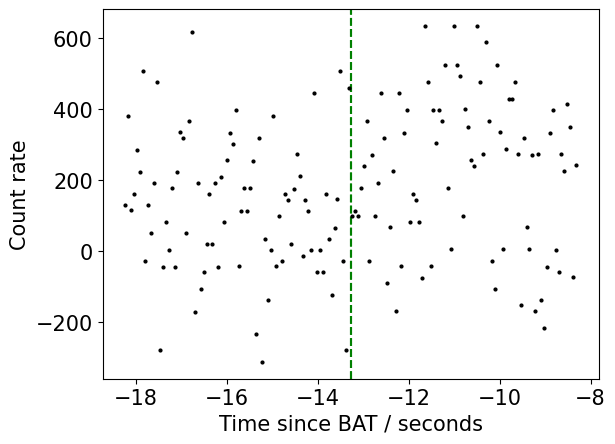

//////////////////////////////////////////////////////////// GRB161129A ////////////////////////////////////////////////////////////
0.724
------------------------------------------------------------ Tpre ------------------------------------------------------------


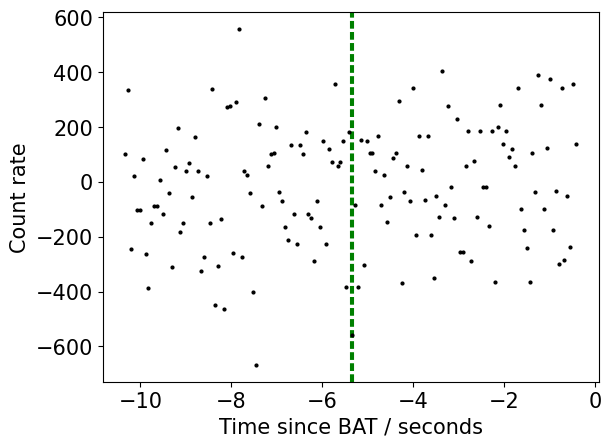

//////////////////////////////////////////////////////////// GRB141102A ////////////////////////////////////////////////////////////
0.326
------------------------------------------------------------ Tpre ------------------------------------------------------------


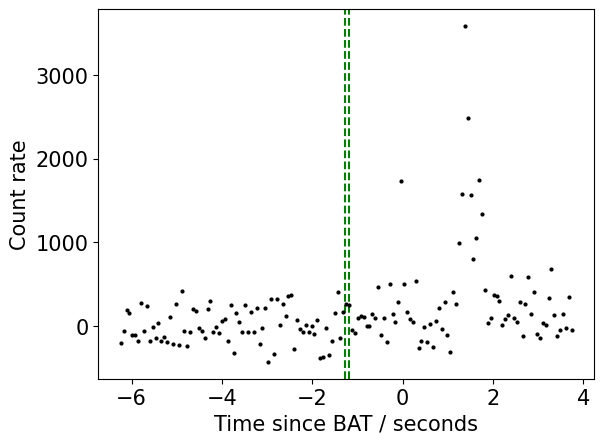

//////////////////////////////////////////////////////////// GRB090929A ////////////////////////////////////////////////////////////
1.298
------------------------------------------------------------ Tpre ------------------------------------------------------------


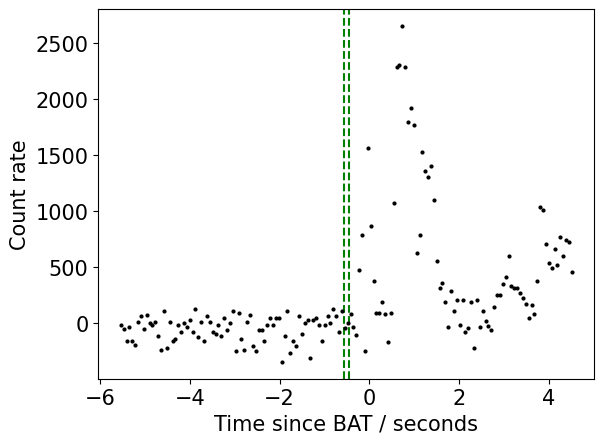

//////////////////////////////////////////////////////////// GRB090113A ////////////////////////////////////////////////////////////
3.238
------------------------------------------------------------ Tpre ------------------------------------------------------------


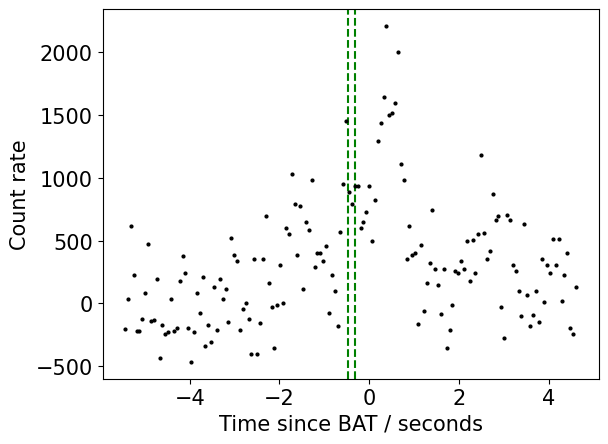

//////////////////////////////////////////////////////////// GRB170402B ////////////////////////////////////////////////////////////
1.143
------------------------------------------------------------ Tpre ------------------------------------------------------------


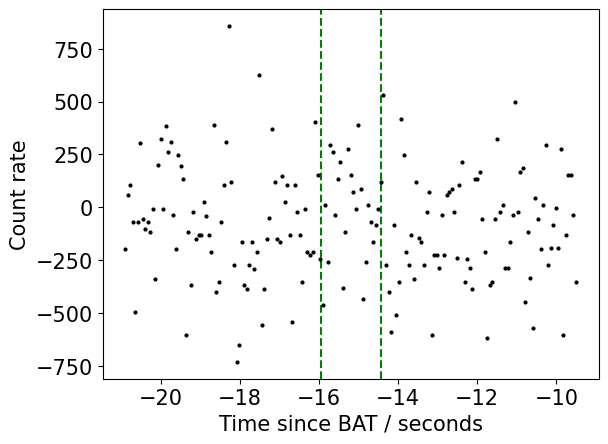

//////////////////////////////////////////////////////////// GRB090720B ////////////////////////////////////////////////////////////
1.056
------------------------------------------------------------ Tpre ------------------------------------------------------------


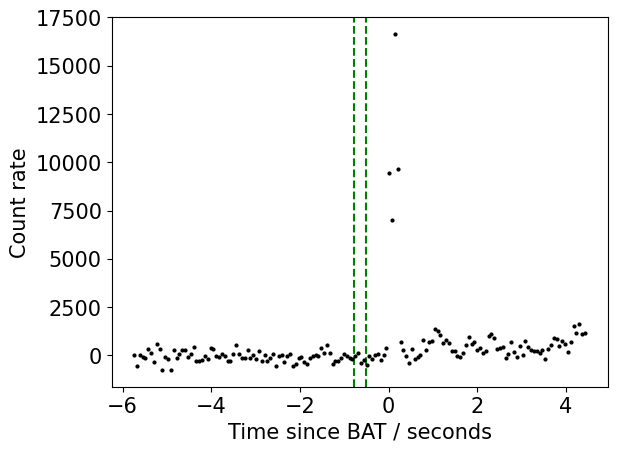

//////////////////////////////////////////////////////////// GRB181122A ////////////////////////////////////////////////////////////
2.996
------------------------------------------------------------ Tpre ------------------------------------------------------------


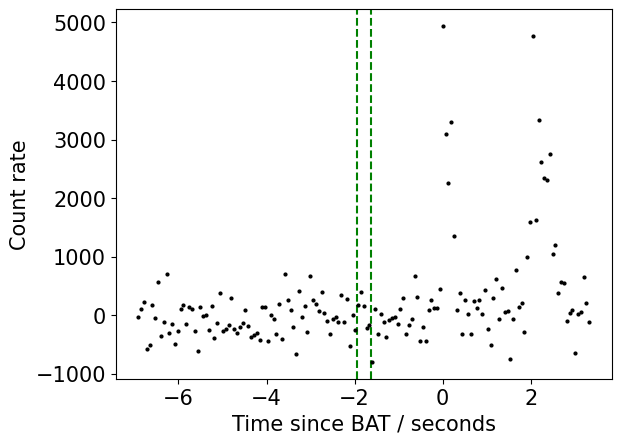

//////////////////////////////////////////////////////////// GRB160919A ////////////////////////////////////////////////////////////
3.665
------------------------------------------------------------ Tpre ------------------------------------------------------------


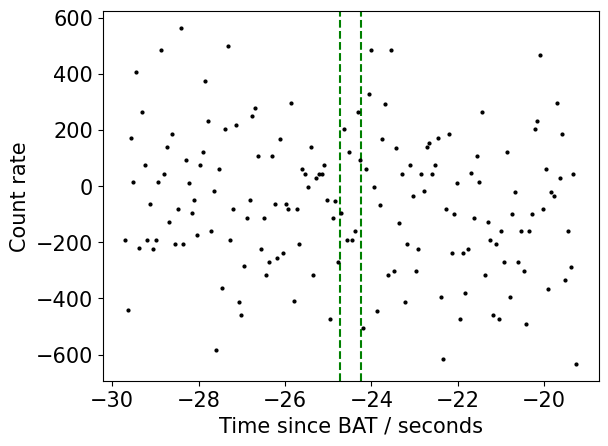

//////////////////////////////////////////////////////////// GRB160825A ////////////////////////////////////////////////////////////
0.362
------------------------------------------------------------ Tpre ------------------------------------------------------------


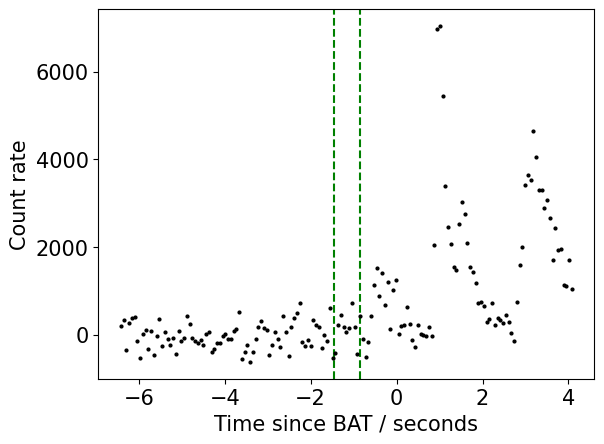

//////////////////////////////////////////////////////////// GRB180929A ////////////////////////////////////////////////////////////
0.345
------------------------------------------------------------ Tpre ------------------------------------------------------------


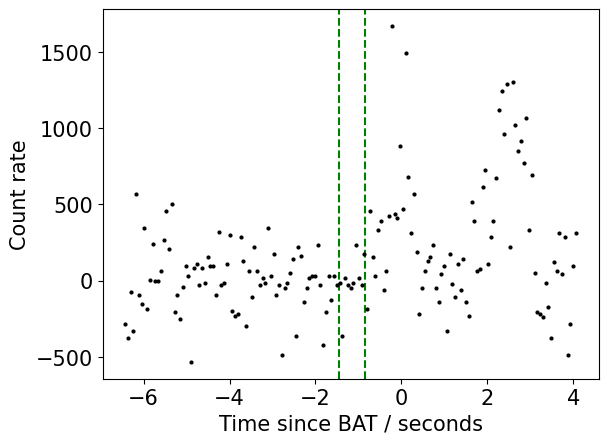

//////////////////////////////////////////////////////////// GRB180124A ////////////////////////////////////////////////////////////
2.919
------------------------------------------------------------ Tpre ------------------------------------------------------------


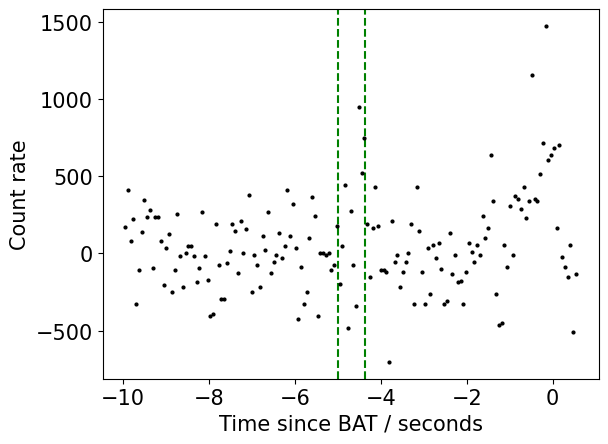

//////////////////////////////////////////////////////////// GRB140329A ////////////////////////////////////////////////////////////
1.056
------------------------------------------------------------ Tpre ------------------------------------------------------------


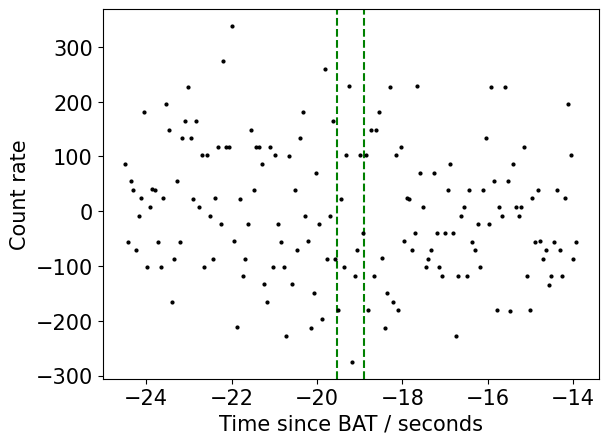

//////////////////////////////////////////////////////////// GRB170514B ////////////////////////////////////////////////////////////
2.828
------------------------------------------------------------ Tpre ------------------------------------------------------------


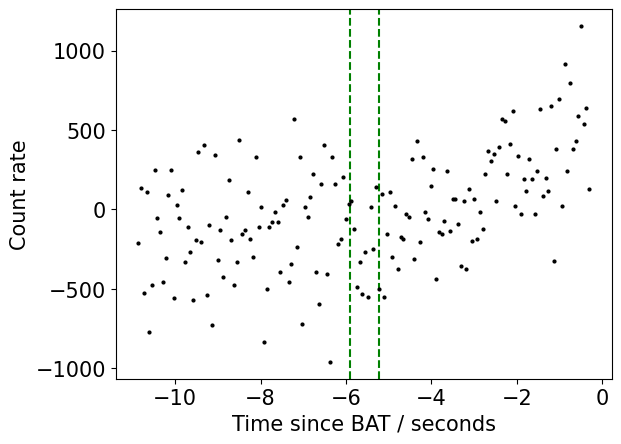

//////////////////////////////////////////////////////////// GRB090602A ////////////////////////////////////////////////////////////
7.209
------------------------------------------------------------ Tpre ------------------------------------------------------------


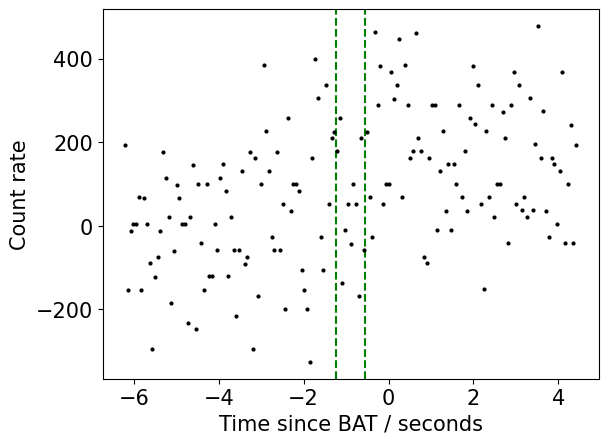

//////////////////////////////////////////////////////////// GRB140621A ////////////////////////////////////////////////////////////
0.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


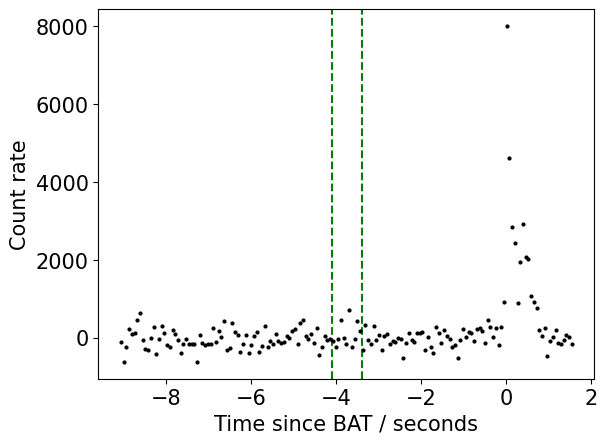

//////////////////////////////////////////////////////////// GRB160919A ////////////////////////////////////////////////////////////
3.665
------------------------------------------------------------ Tpre ------------------------------------------------------------


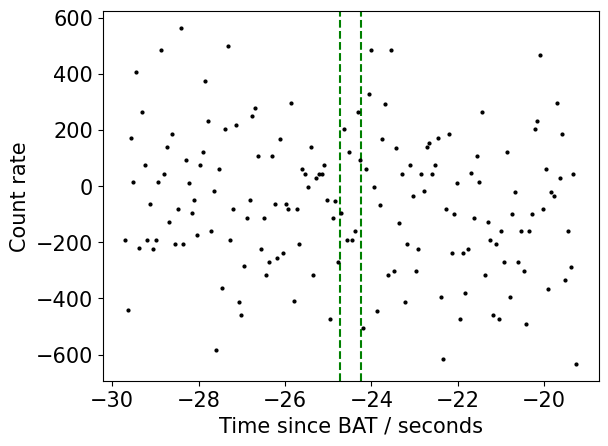

//////////////////////////////////////////////////////////// GRB120504B ////////////////////////////////////////////////////////////
0.779
------------------------------------------------------------ Tpre ------------------------------------------------------------


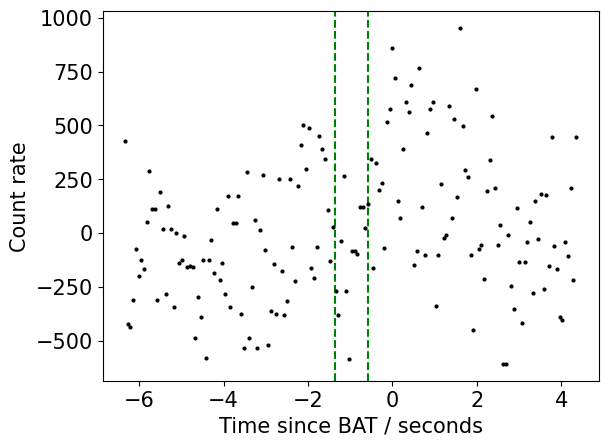

//////////////////////////////////////////////////////////// GRB110825A ////////////////////////////////////////////////////////////
0.231
------------------------------------------------------------ Tpre ------------------------------------------------------------


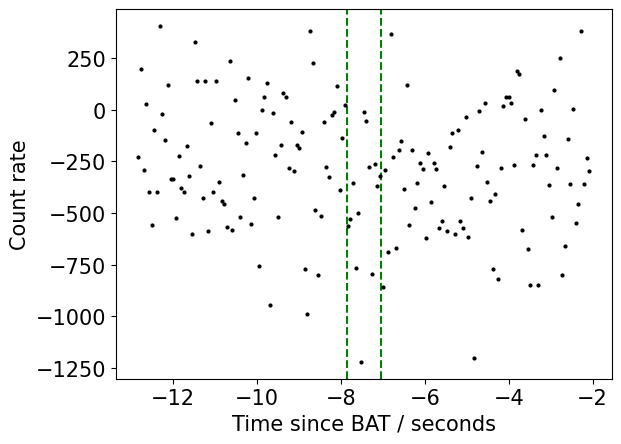

//////////////////////////////////////////////////////////// GRB181203B ////////////////////////////////////////////////////////////
2.573
------------------------------------------------------------ Tpre ------------------------------------------------------------


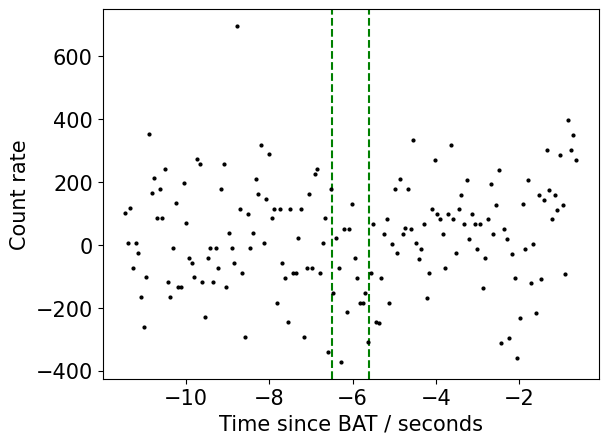

//////////////////////////////////////////////////////////// GRB160201A ////////////////////////////////////////////////////////////
6.152
------------------------------------------------------------ Tpre ------------------------------------------------------------


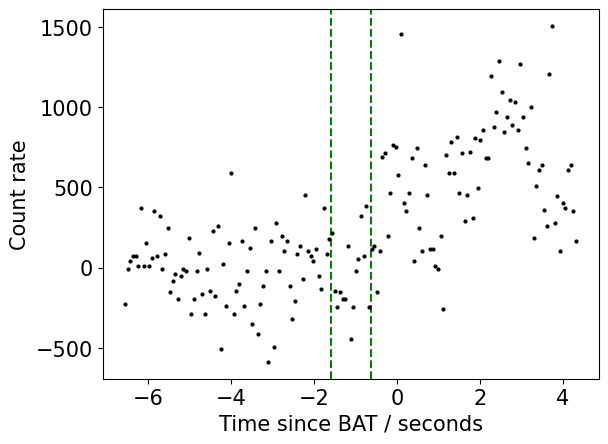

//////////////////////////////////////////////////////////// GRB170923B ////////////////////////////////////////////////////////////
2.58
------------------------------------------------------------ Tpre ------------------------------------------------------------


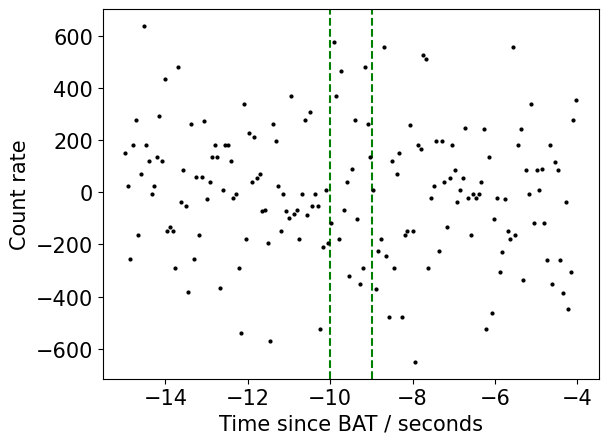

//////////////////////////////////////////////////////////// GRB080807A ////////////////////////////////////////////////////////////
0.181
------------------------------------------------------------ Tpre ------------------------------------------------------------


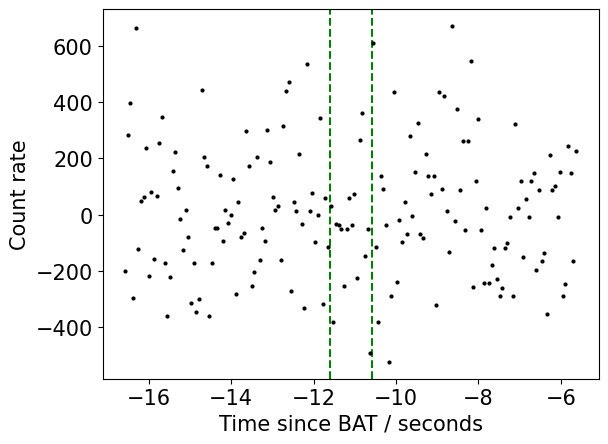

//////////////////////////////////////////////////////////// GRB180906C ////////////////////////////////////////////////////////////
0.362
------------------------------------------------------------ Tpre ------------------------------------------------------------


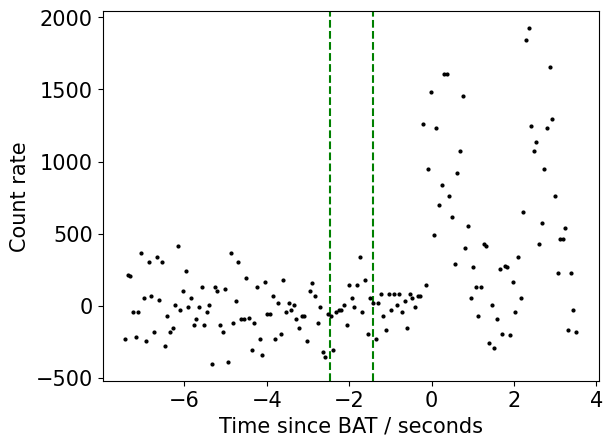

//////////////////////////////////////////////////////////// GRB190610B ////////////////////////////////////////////////////////////
4.924
------------------------------------------------------------ Tpre ------------------------------------------------------------


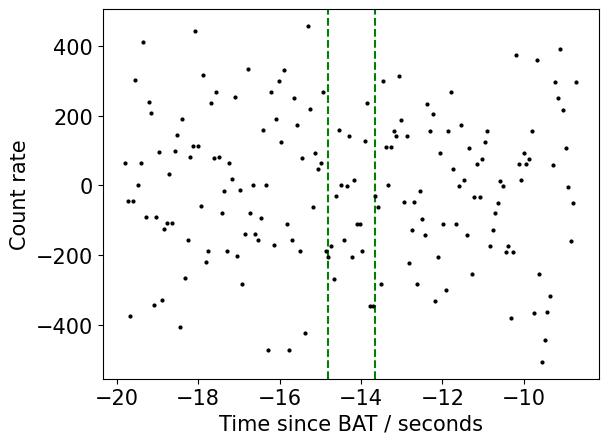

//////////////////////////////////////////////////////////// GRB190806A ////////////////////////////////////////////////////////////
2.374
------------------------------------------------------------ Tpre ------------------------------------------------------------


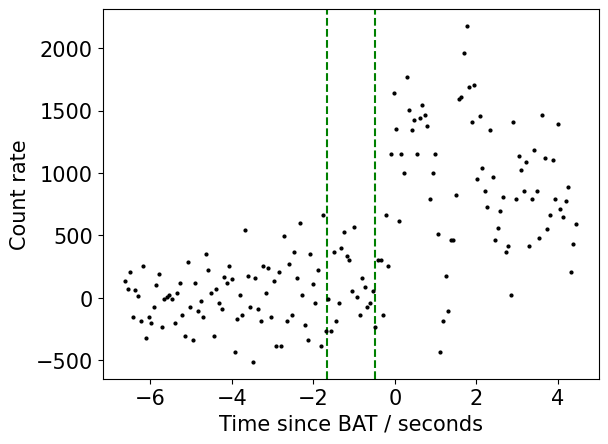

//////////////////////////////////////////////////////////// GRB130310A ////////////////////////////////////////////////////////////
2.561
------------------------------------------------------------ Tpre ------------------------------------------------------------


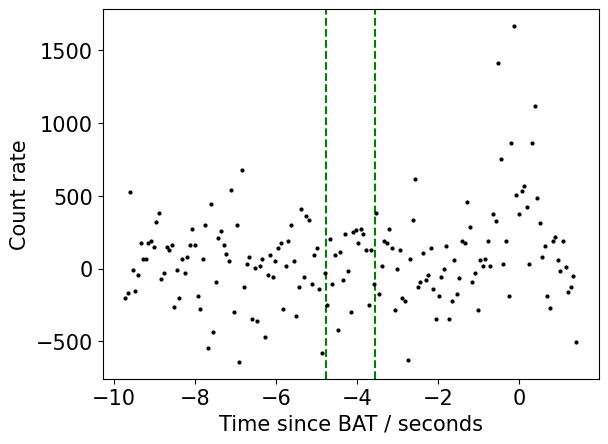

//////////////////////////////////////////////////////////// GRB111230B ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


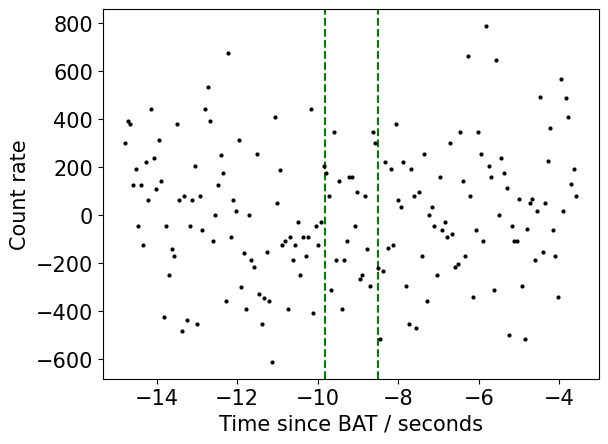

//////////////////////////////////////////////////////////// GRB120513A ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


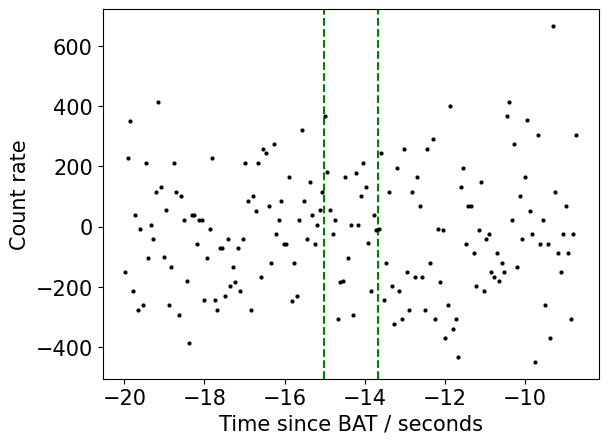

//////////////////////////////////////////////////////////// GRB100517C ////////////////////////////////////////////////////////////
0.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


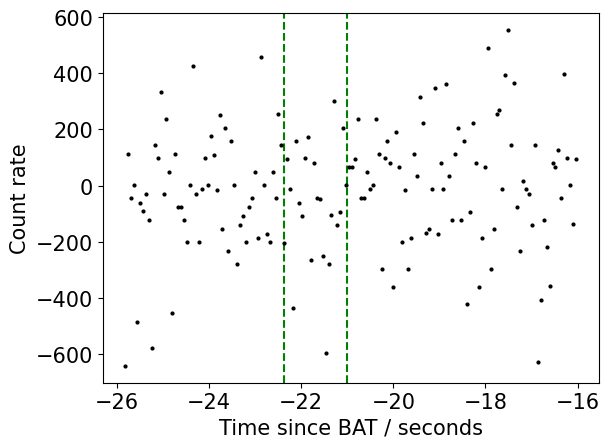

//////////////////////////////////////////////////////////// GRB171004C ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


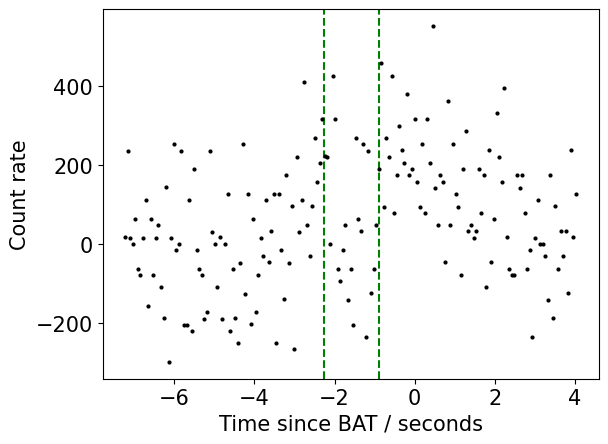

//////////////////////////////////////////////////////////// GRB140104B ////////////////////////////////////////////////////////////
2.996
------------------------------------------------------------ Tpre ------------------------------------------------------------


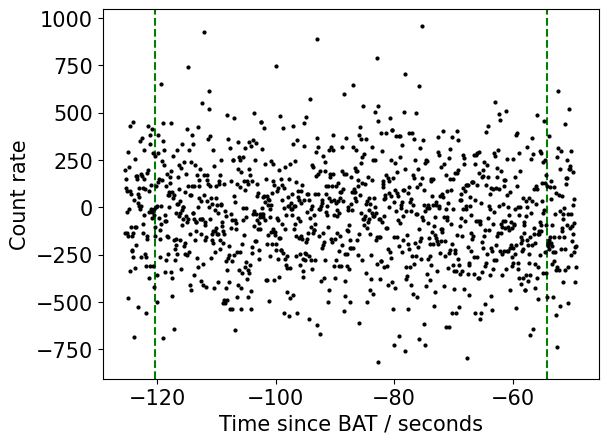

//////////////////////////////////////////////////////////// GRB170402B ////////////////////////////////////////////////////////////
1.143
------------------------------------------------------------ Tpre ------------------------------------------------------------


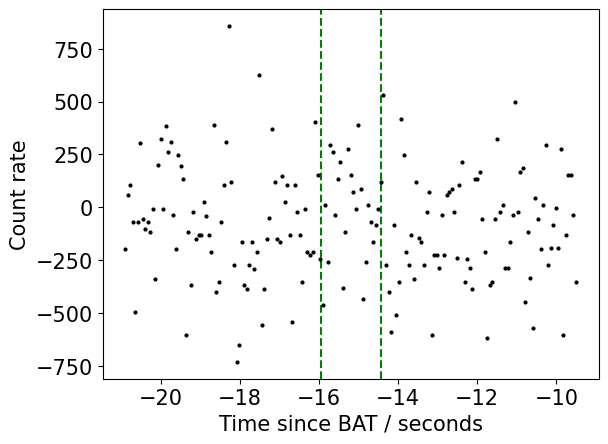

//////////////////////////////////////////////////////////// GRB190114C ////////////////////////////////////////////////////////////
2.563
------------------------------------------------------------ Tpre ------------------------------------------------------------


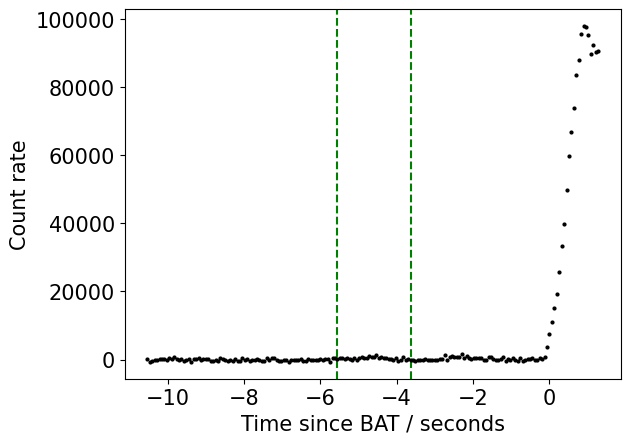

//////////////////////////////////////////////////////////// GRB190719C ////////////////////////////////////////////////////////////
3.083
------------------------------------------------------------ Tpre ------------------------------------------------------------


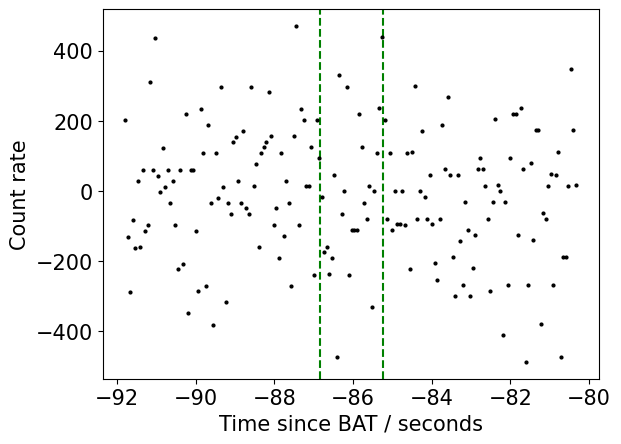

//////////////////////////////////////////////////////////// GRB090811A ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


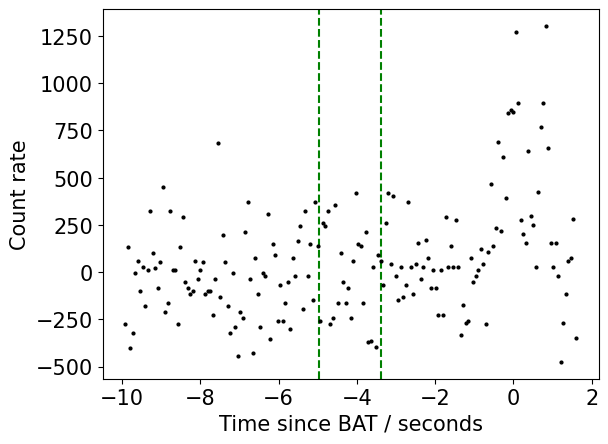

//////////////////////////////////////////////////////////// GRB090907A ////////////////////////////////////////////////////////////
4.443
------------------------------------------------------------ Tpre ------------------------------------------------------------


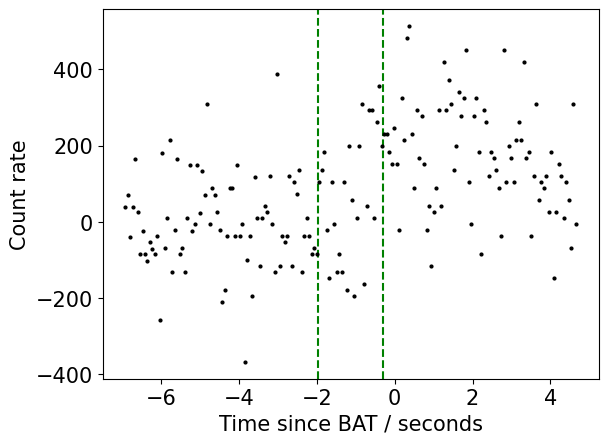

//////////////////////////////////////////////////////////// GRB110909A ////////////////////////////////////////////////////////////
1.639
------------------------------------------------------------ Tpre ------------------------------------------------------------


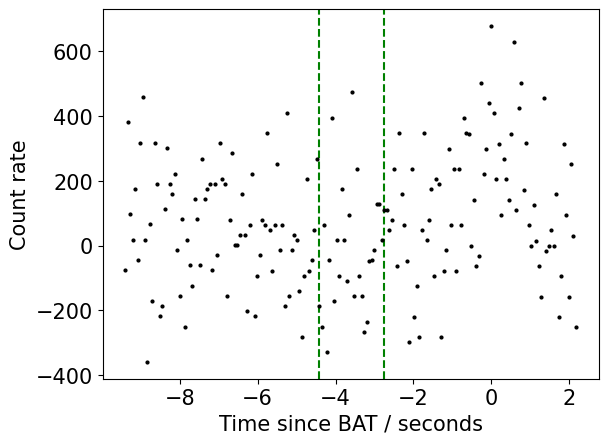

//////////////////////////////////////////////////////////// GRB190326B ////////////////////////////////////////////////////////////
0.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


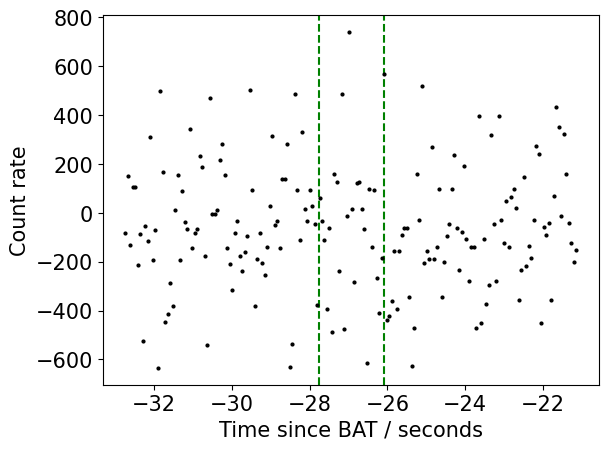

//////////////////////////////////////////////////////////// GRB130813A ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


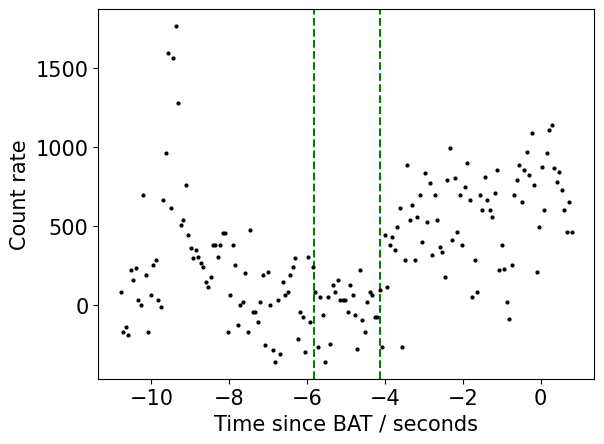

//////////////////////////////////////////////////////////// GRB160724A ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


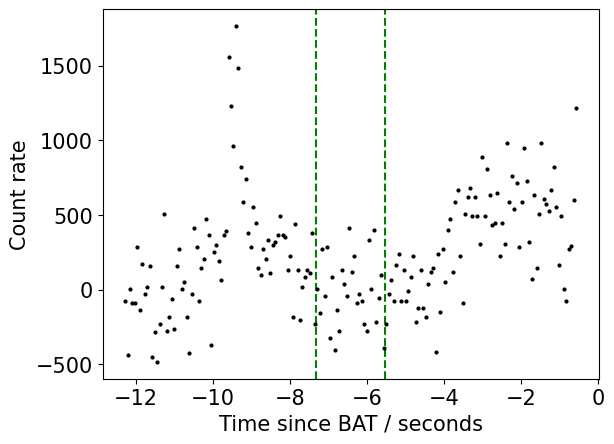

//////////////////////////////////////////////////////////// GRB181119A ////////////////////////////////////////////////////////////
0.602
------------------------------------------------------------ Tpre ------------------------------------------------------------


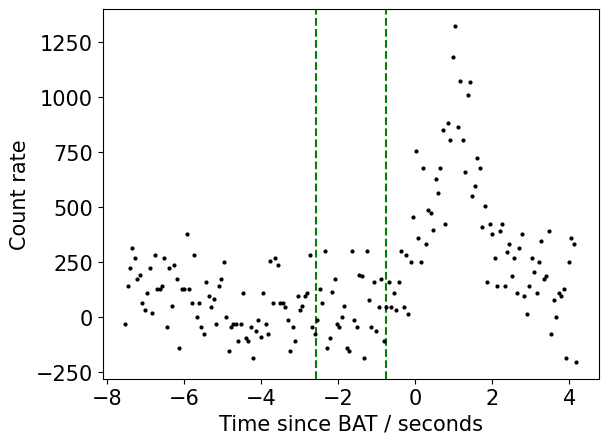

//////////////////////////////////////////////////////////// GRB131108B ////////////////////////////////////////////////////////////
3.999
------------------------------------------------------------ Tpre ------------------------------------------------------------


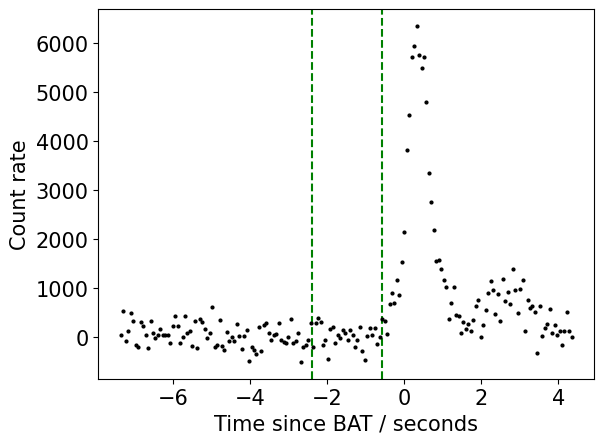

//////////////////////////////////////////////////////////// GRB130623B ////////////////////////////////////////////////////////////
0.724
------------------------------------------------------------ Tpre ------------------------------------------------------------


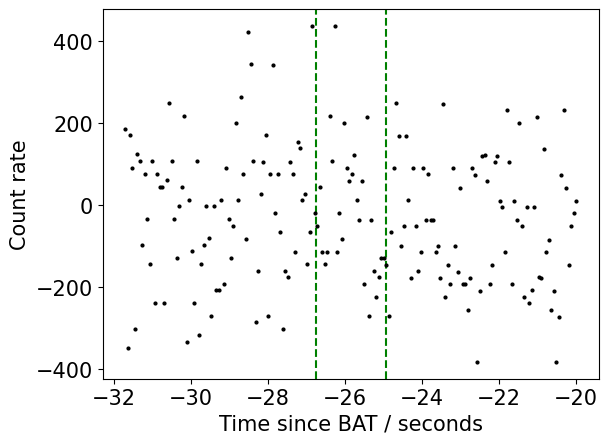

//////////////////////////////////////////////////////////// GRB080816A ////////////////////////////////////////////////////////////
1.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


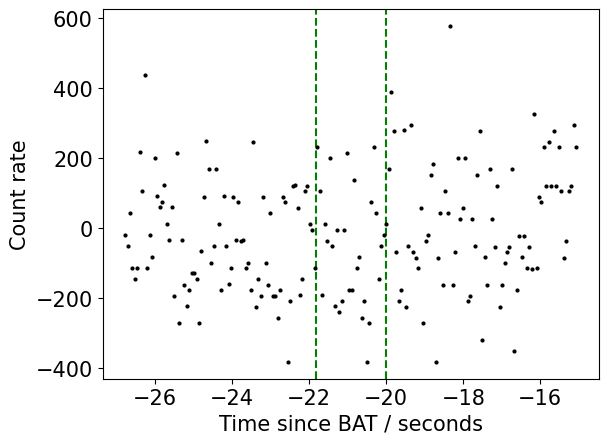

//////////////////////////////////////////////////////////// GRB191101B ////////////////////////////////////////////////////////////
1.086
------------------------------------------------------------ Tpre ------------------------------------------------------------


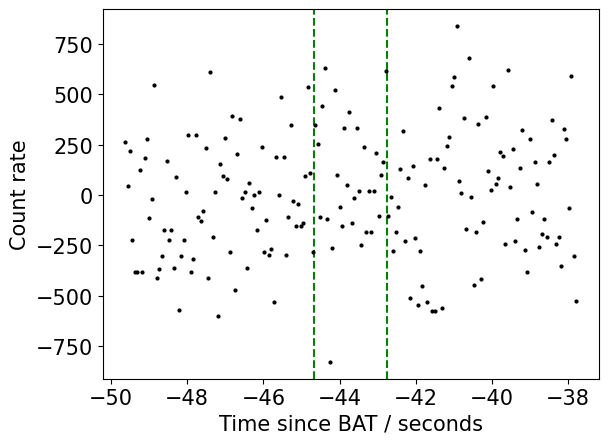

//////////////////////////////////////////////////////////// GRB190114C ////////////////////////////////////////////////////////////
2.563
------------------------------------------------------------ Tpre ------------------------------------------------------------


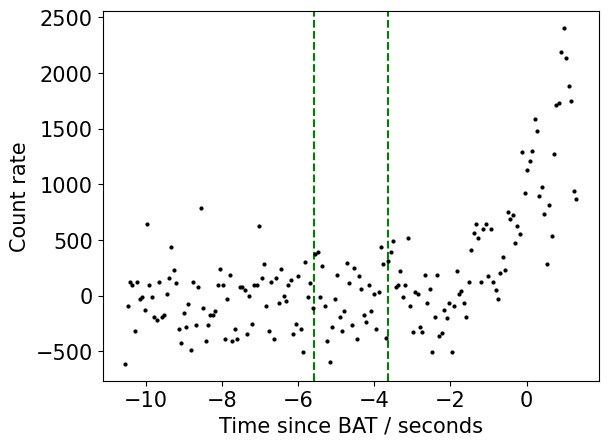

//////////////////////////////////////////////////////////// GRB191225A ////////////////////////////////////////////////////////////
11.31
------------------------------------------------------------ Tpre ------------------------------------------------------------


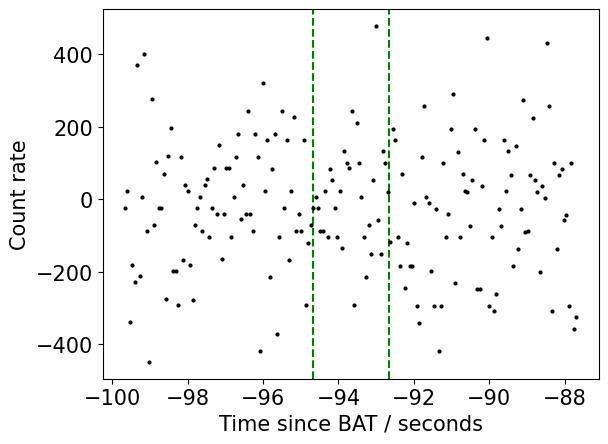

//////////////////////////////////////////////////////////// GRB131014B ////////////////////////////////////////////////////////////
4.636
------------------------------------------------------------ Tpre ------------------------------------------------------------


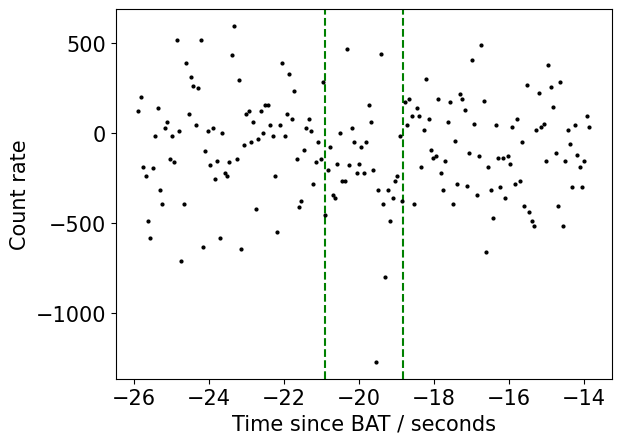

//////////////////////////////////////////////////////////// GRB190326B ////////////////////////////////////////////////////////////
0.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


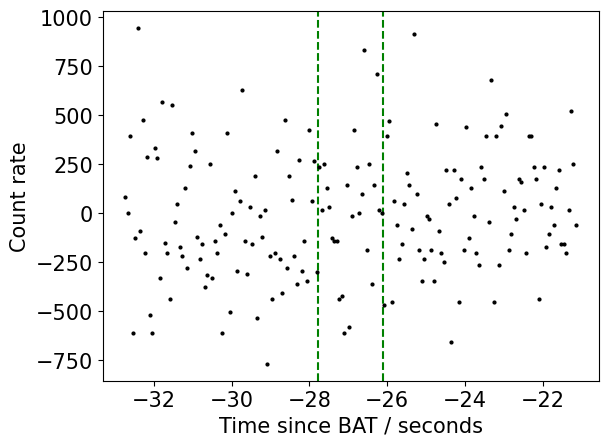

//////////////////////////////////////////////////////////// GRB140716A ////////////////////////////////////////////////////////////
53.762
------------------------------------------------------------ Tpre ------------------------------------------------------------


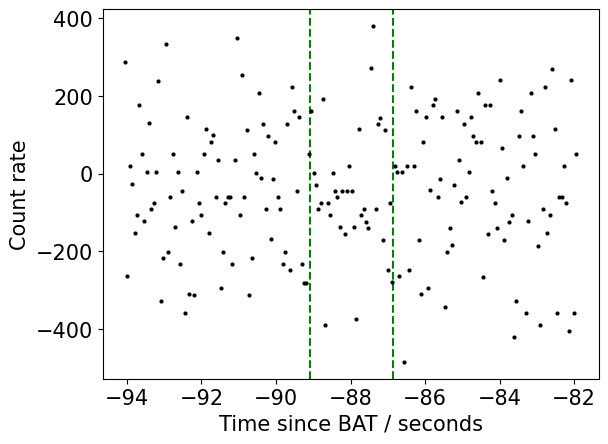

//////////////////////////////////////////////////////////// GRB190324A ////////////////////////////////////////////////////////////
9.941
------------------------------------------------------------ Tpre ------------------------------------------------------------


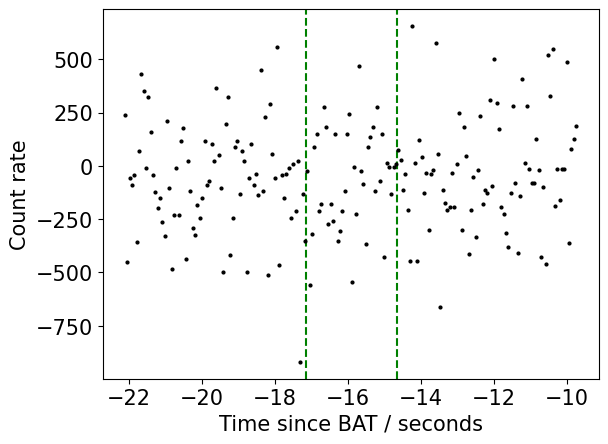

//////////////////////////////////////////////////////////// GRB150702A ////////////////////////////////////////////////////////////
2.064
------------------------------------------------------------ Tpre ------------------------------------------------------------


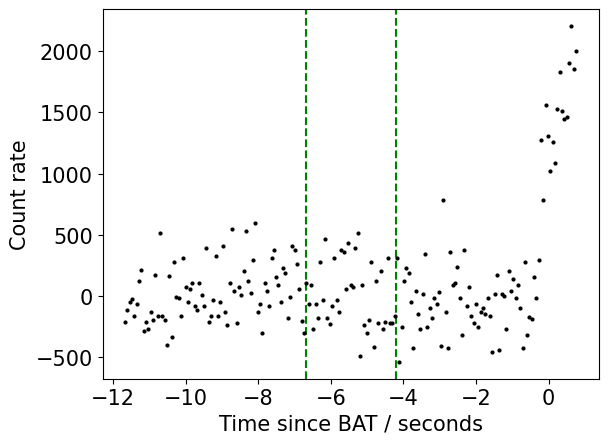

//////////////////////////////////////////////////////////// GRB091109C ////////////////////////////////////////////////////////////
4.58
------------------------------------------------------------ Tpre ------------------------------------------------------------


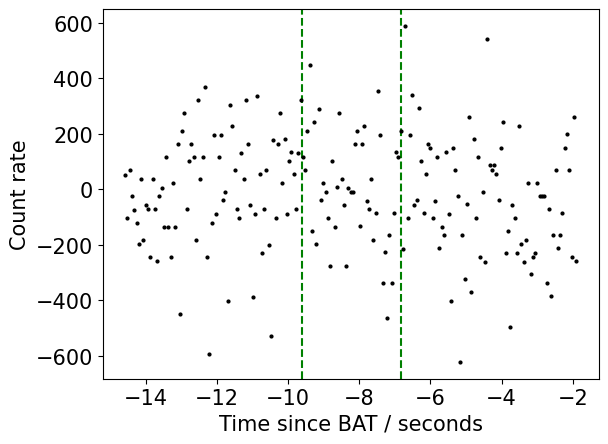

//////////////////////////////////////////////////////////// GRB180822A ////////////////////////////////////////////////////////////
0.724
------------------------------------------------------------ Tpre ------------------------------------------------------------


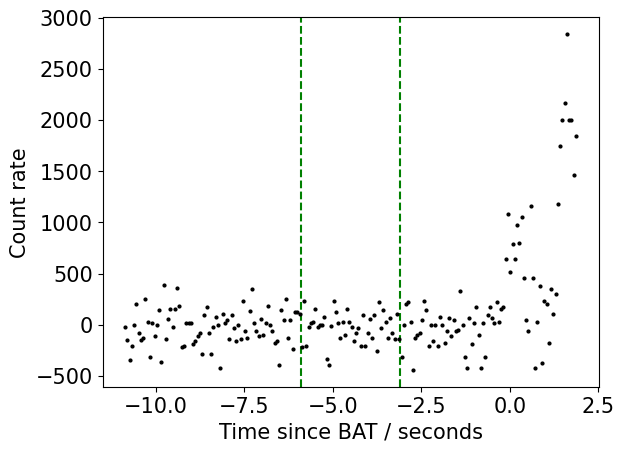

//////////////////////////////////////////////////////////// GRB120308B ////////////////////////////////////////////////////////////
1.557
------------------------------------------------------------ Tpre ------------------------------------------------------------


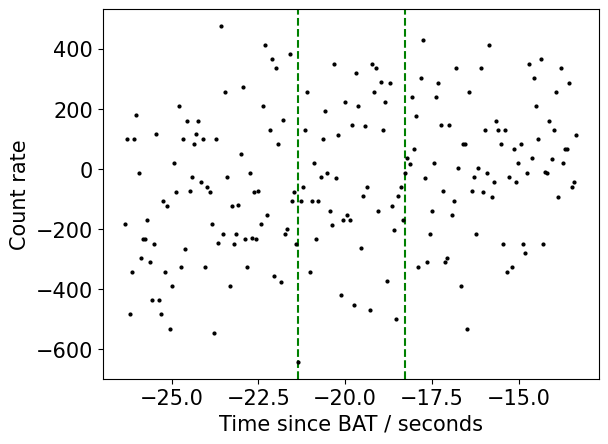

//////////////////////////////////////////////////////////// GRB140825B ////////////////////////////////////////////////////////////
5.184
------------------------------------------------------------ Tpre ------------------------------------------------------------


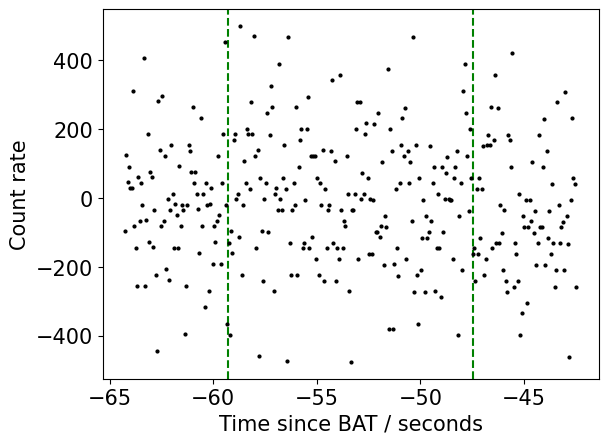

//////////////////////////////////////////////////////////// GRB160519A ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


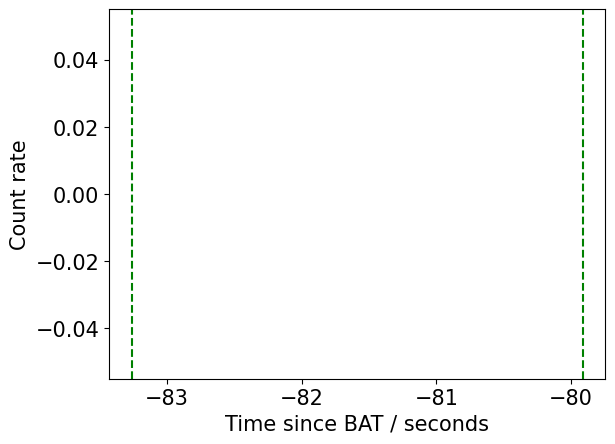

//////////////////////////////////////////////////////////// GRB101227C ////////////////////////////////////////////////////////////
3.088
------------------------------------------------------------ Tpre ------------------------------------------------------------


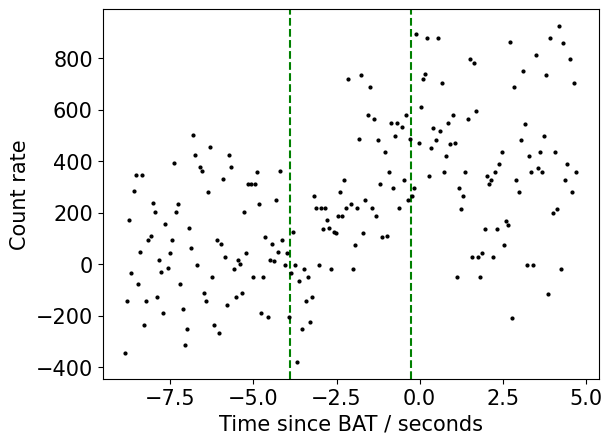

//////////////////////////////////////////////////////////// GRB141029B ////////////////////////////////////////////////////////////
1.95
------------------------------------------------------------ Tpre ------------------------------------------------------------


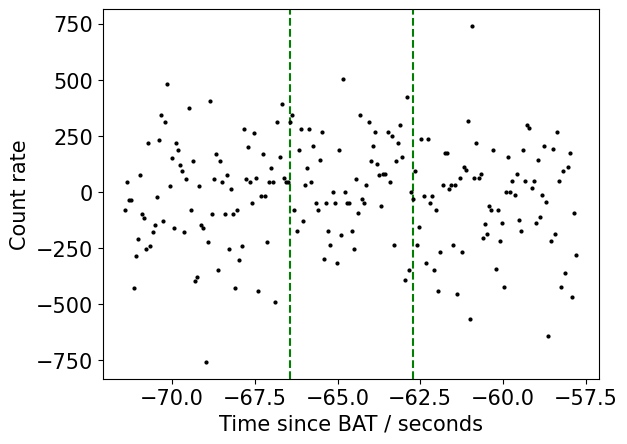

//////////////////////////////////////////////////////////// GRB130104A ////////////////////////////////////////////////////////////
3.593
------------------------------------------------------------ Tpre ------------------------------------------------------------


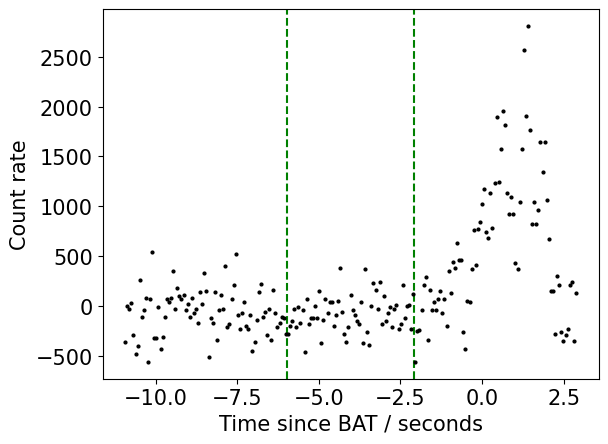

//////////////////////////////////////////////////////////// GRB140917A ////////////////////////////////////////////////////////////
0.689
------------------------------------------------------------ Tpre ------------------------------------------------------------


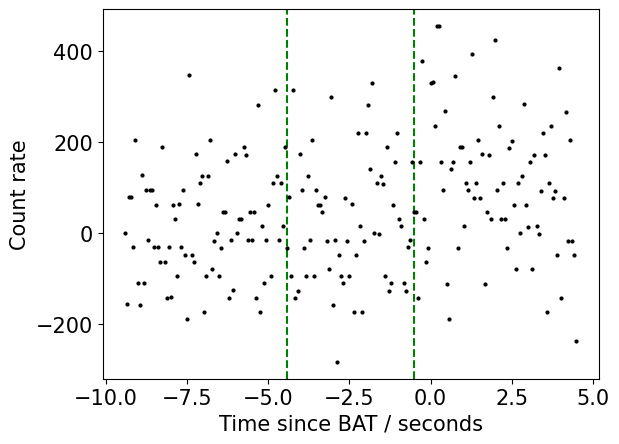

//////////////////////////////////////////////////////////// GRB181007A ////////////////////////////////////////////////////////////
8.452
------------------------------------------------------------ Tpre ------------------------------------------------------------


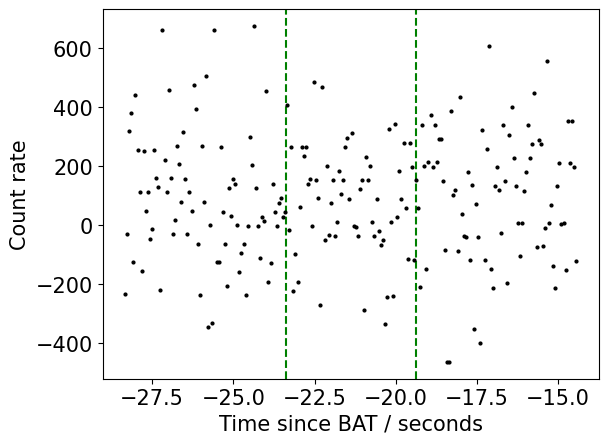

//////////////////////////////////////////////////////////// GRB100923A ////////////////////////////////////////////////////////////
5.838
------------------------------------------------------------ Tpre ------------------------------------------------------------


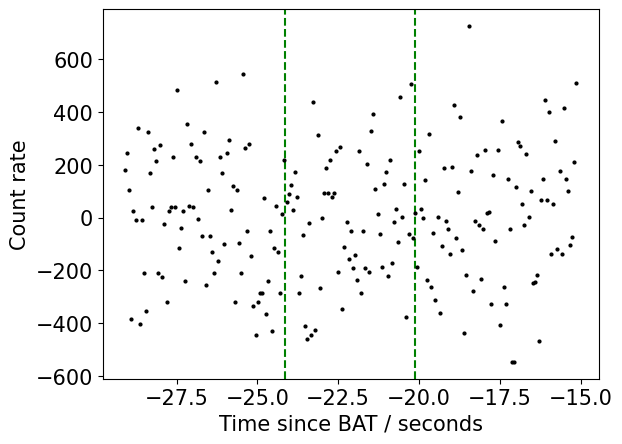

//////////////////////////////////////////////////////////// GRB100625B ////////////////////////////////////////////////////////////
1.086
------------------------------------------------------------ Tpre ------------------------------------------------------------


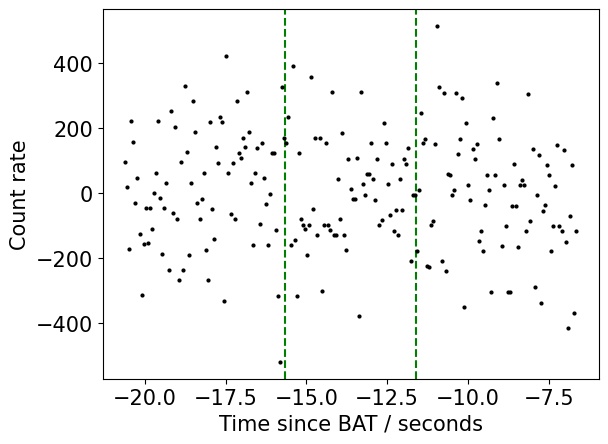

//////////////////////////////////////////////////////////// GRB191026A ////////////////////////////////////////////////////////////
4.944
------------------------------------------------------------ Tpre ------------------------------------------------------------


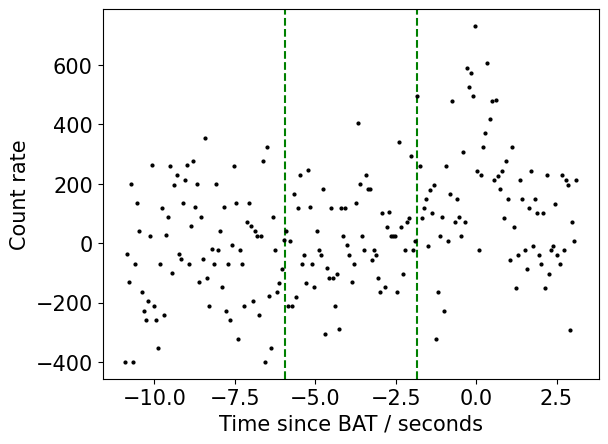

//////////////////////////////////////////////////////////// GRB190310A ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


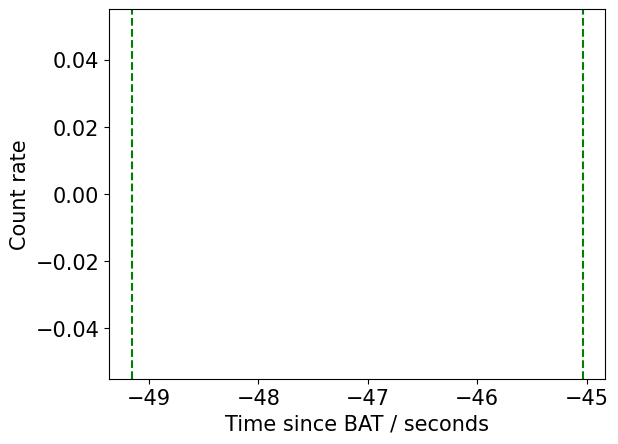

//////////////////////////////////////////////////////////// GRB090820B ////////////////////////////////////////////////////////////
4.61
------------------------------------------------------------ Tpre ------------------------------------------------------------


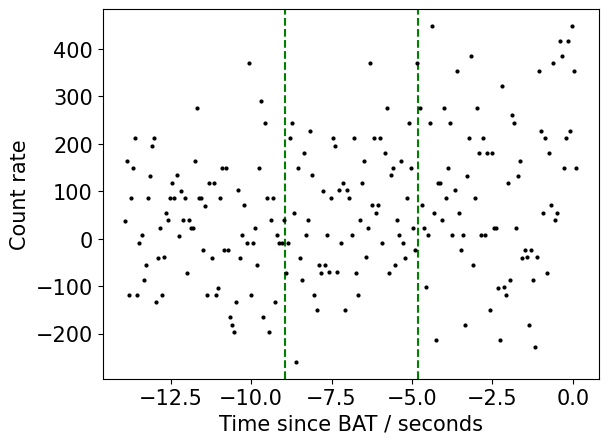

//////////////////////////////////////////////////////////// GRB171120A ////////////////////////////////////////////////////////////
0.383
------------------------------------------------------------ Tpre ------------------------------------------------------------


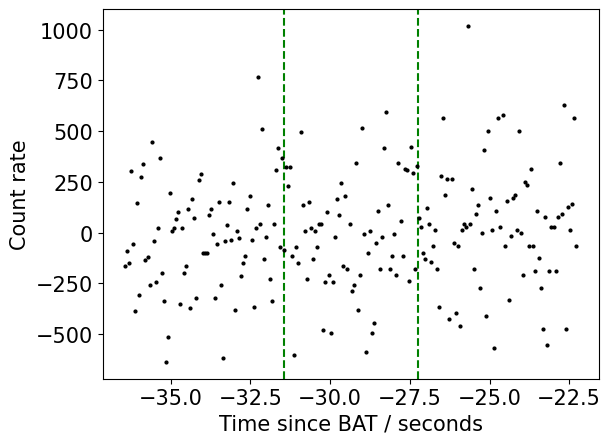

//////////////////////////////////////////////////////////// GRB111230B ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


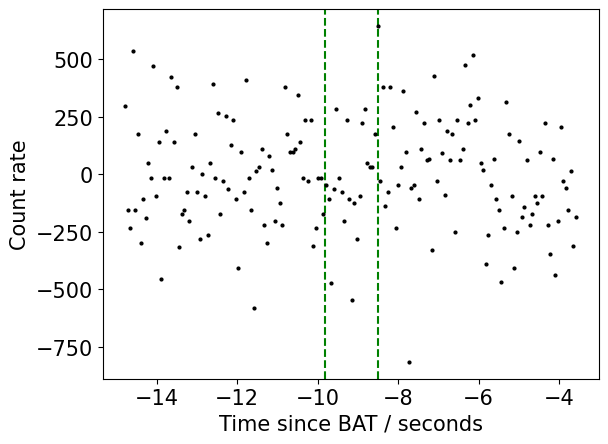

//////////////////////////////////////////////////////////// GRB081003C ////////////////////////////////////////////////////////////
3.692
------------------------------------------------------------ Tpre ------------------------------------------------------------


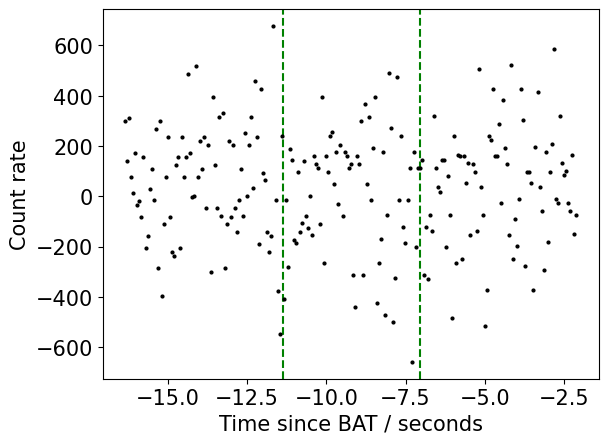

//////////////////////////////////////////////////////////// GRB130209A ////////////////////////////////////////////////////////////
0.408
------------------------------------------------------------ Tpre ------------------------------------------------------------


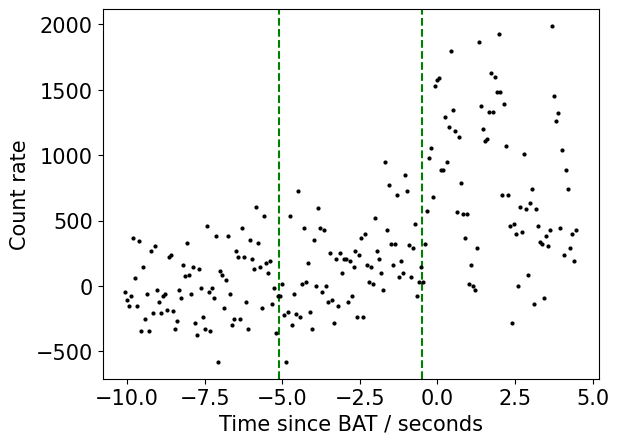

//////////////////////////////////////////////////////////// GRB111230A ////////////////////////////////////////////////////////////
1.557
------------------------------------------------------------ Tpre ------------------------------------------------------------


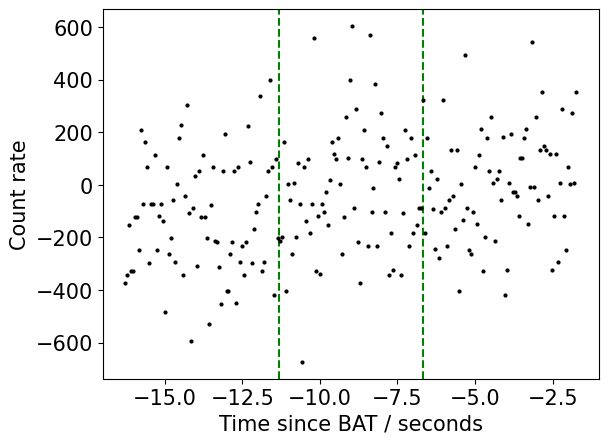

//////////////////////////////////////////////////////////// GRB140628C ////////////////////////////////////////////////////////////
3.849
------------------------------------------------------------ Tpre ------------------------------------------------------------


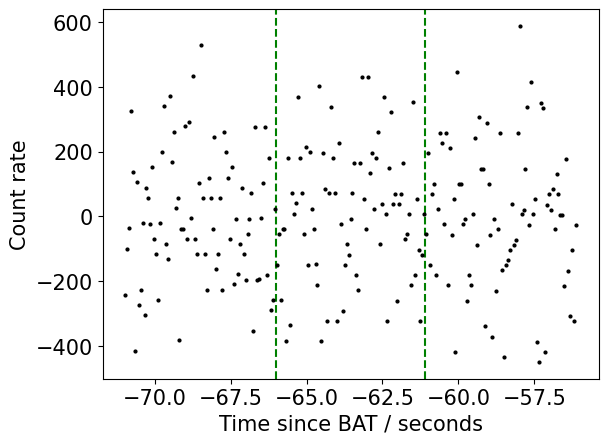

//////////////////////////////////////////////////////////// GRB130208A ////////////////////////////////////////////////////////////
2.36
------------------------------------------------------------ Tpre ------------------------------------------------------------


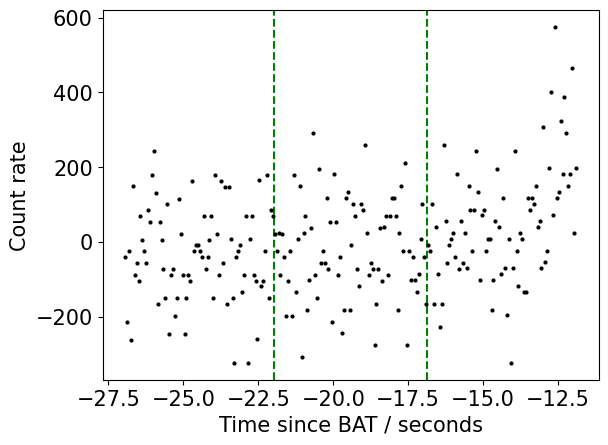

//////////////////////////////////////////////////////////// GRB080830A ////////////////////////////////////////////////////////////
5.069
------------------------------------------------------------ Tpre ------------------------------------------------------------


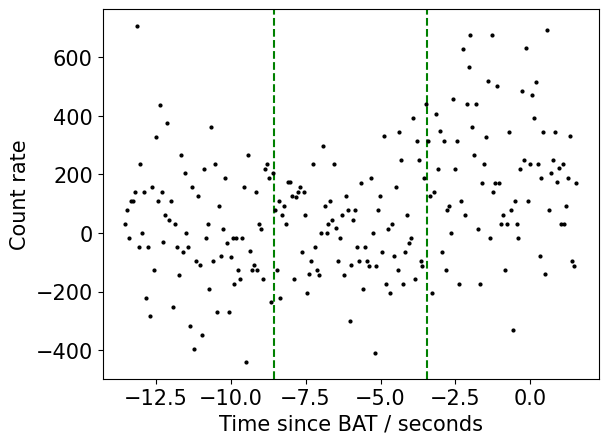

//////////////////////////////////////////////////////////// GRB160912C ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


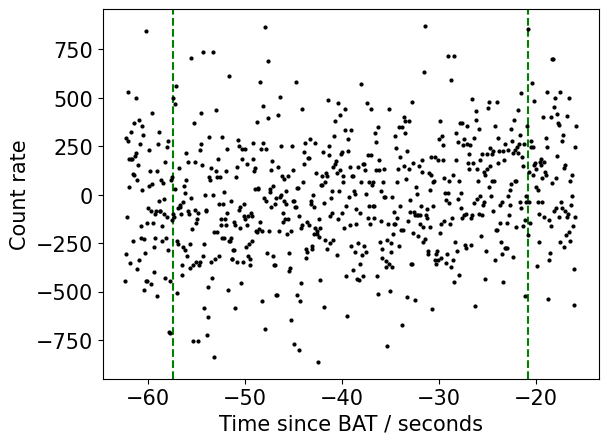

//////////////////////////////////////////////////////////// GRB160523A ////////////////////////////////////////////////////////////
2.111
------------------------------------------------------------ Tpre ------------------------------------------------------------


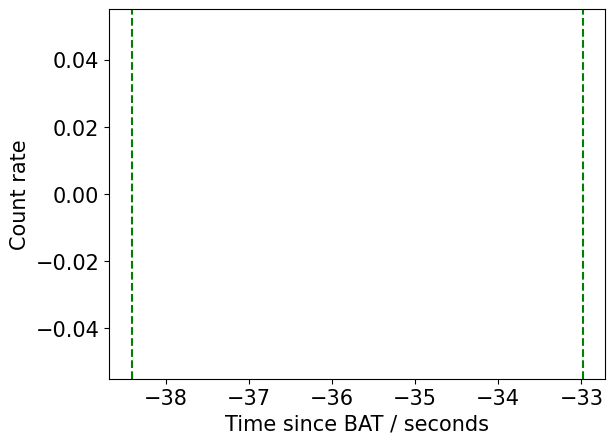

//////////////////////////////////////////////////////////// GRB120118B ////////////////////////////////////////////////////////////
12.586
------------------------------------------------------------ Tpre ------------------------------------------------------------


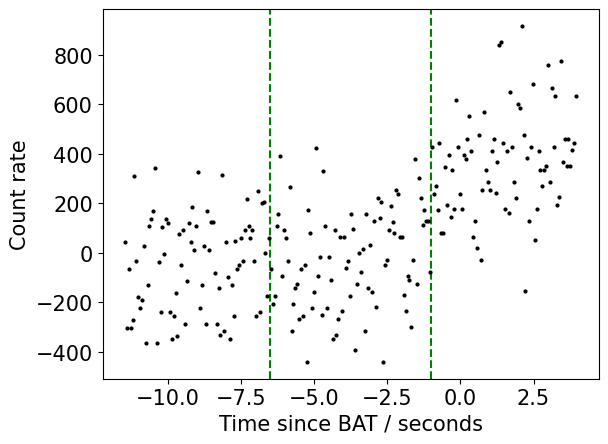

//////////////////////////////////////////////////////////// GRB120319A ////////////////////////////////////////////////////////////
7.832
------------------------------------------------------------ Tpre ------------------------------------------------------------


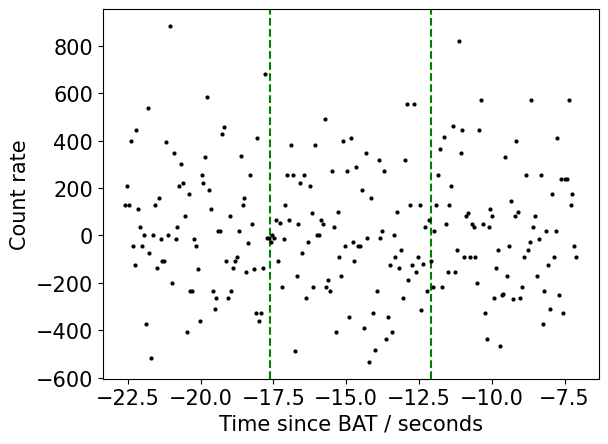

//////////////////////////////////////////////////////////// GRB190829A ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


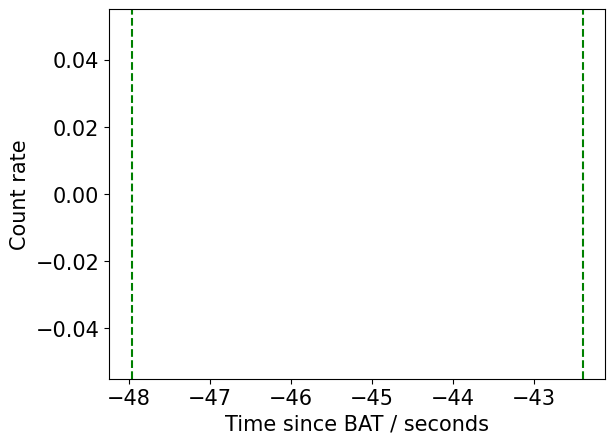

//////////////////////////////////////////////////////////// GRB080818A ////////////////////////////////////////////////////////////
8.749
------------------------------------------------------------ Tpre ------------------------------------------------------------


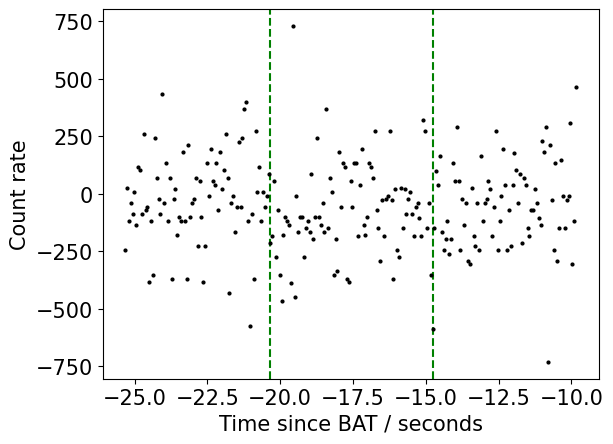

//////////////////////////////////////////////////////////// GRB140709A ////////////////////////////////////////////////////////////
21.549
------------------------------------------------------------ Tpre ------------------------------------------------------------


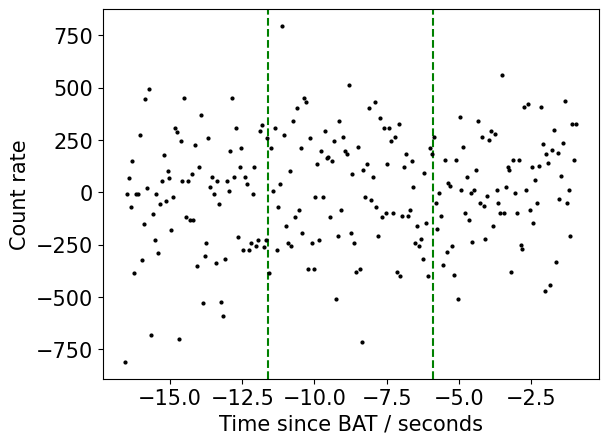

//////////////////////////////////////////////////////////// GRB150127A ////////////////////////////////////////////////////////////
3.62
------------------------------------------------------------ Tpre ------------------------------------------------------------


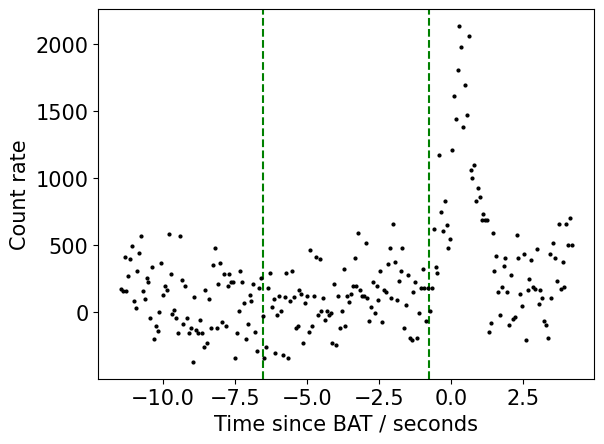

//////////////////////////////////////////////////////////// GRB180620C ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


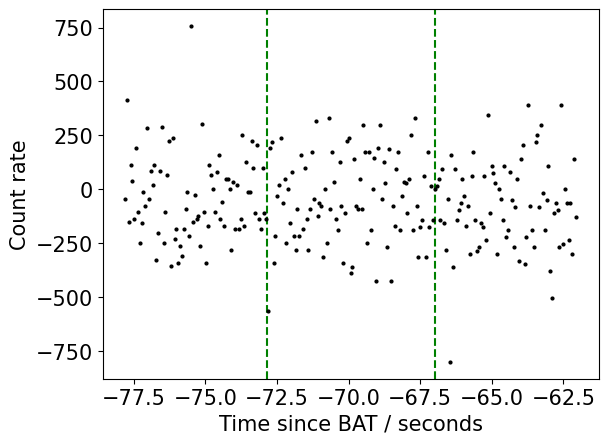

//////////////////////////////////////////////////////////// GRB170830B ////////////////////////////////////////////////////////////
4.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


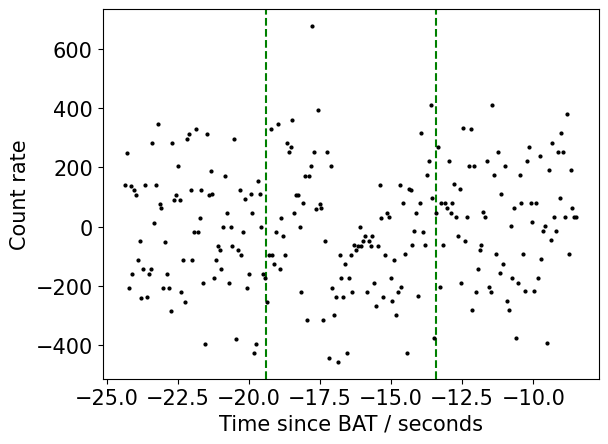

//////////////////////////////////////////////////////////// GRB100718A ////////////////////////////////////////////////////////////
1.864
------------------------------------------------------------ Tpre ------------------------------------------------------------


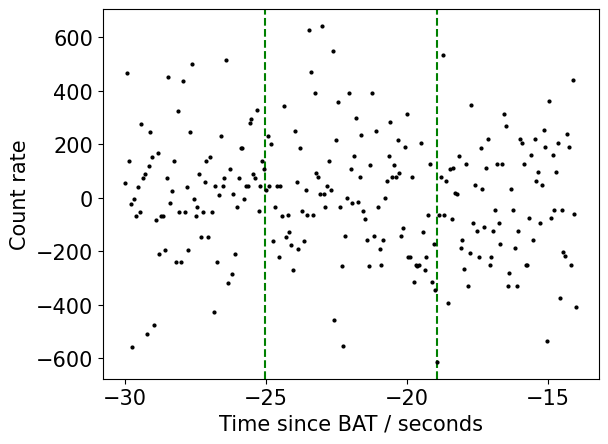

//////////////////////////////////////////////////////////// GRB170831A ////////////////////////////////////////////////////////////
8.738
------------------------------------------------------------ Tpre ------------------------------------------------------------


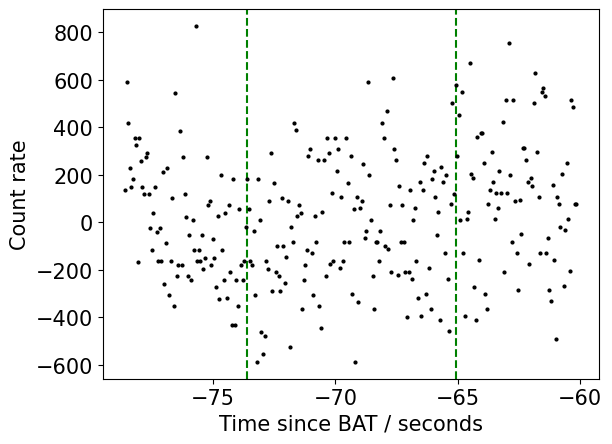

//////////////////////////////////////////////////////////// GRB180822B ////////////////////////////////////////////////////////////
1.639
------------------------------------------------------------ Tpre ------------------------------------------------------------


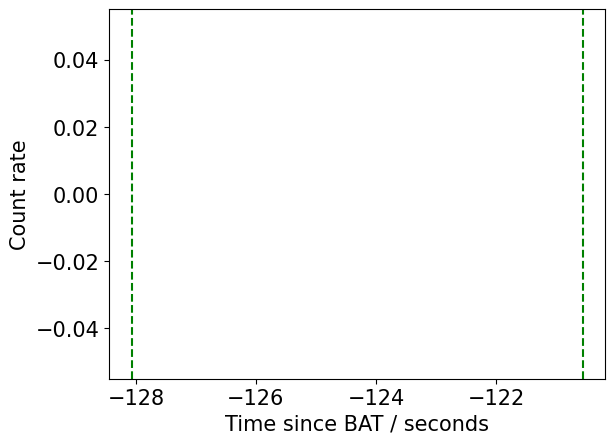

//////////////////////////////////////////////////////////// GRB120611A ////////////////////////////////////////////////////////////
1.639
------------------------------------------------------------ Tpre ------------------------------------------------------------


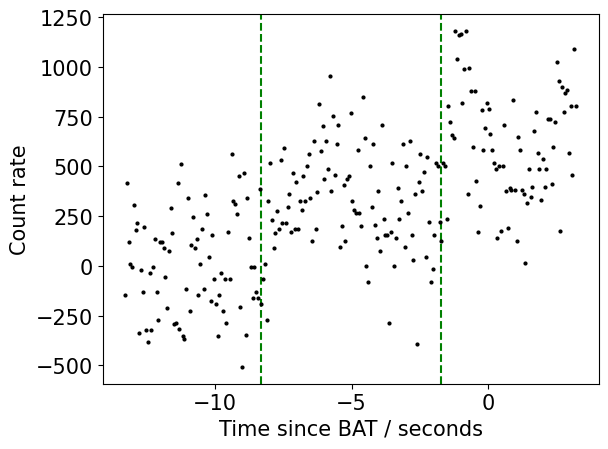

//////////////////////////////////////////////////////////// GRB100718A ////////////////////////////////////////////////////////////
1.864
------------------------------------------------------------ Tpre ------------------------------------------------------------


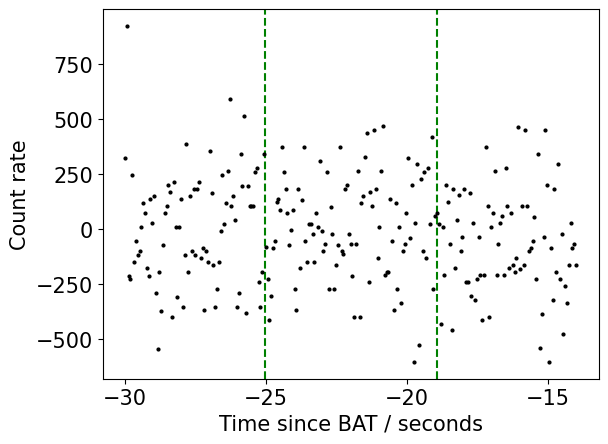

//////////////////////////////////////////////////////////// GRB160908A ////////////////////////////////////////////////////////////
21.722
------------------------------------------------------------ Tpre ------------------------------------------------------------


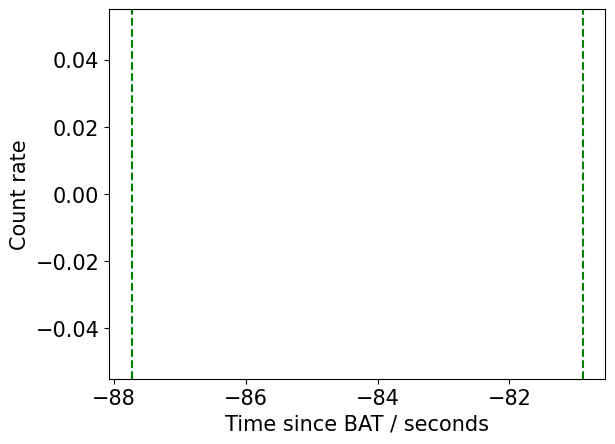

//////////////////////////////////////////////////////////// GRB130318A ////////////////////////////////////////////////////////////
1.448
------------------------------------------------------------ Tpre ------------------------------------------------------------


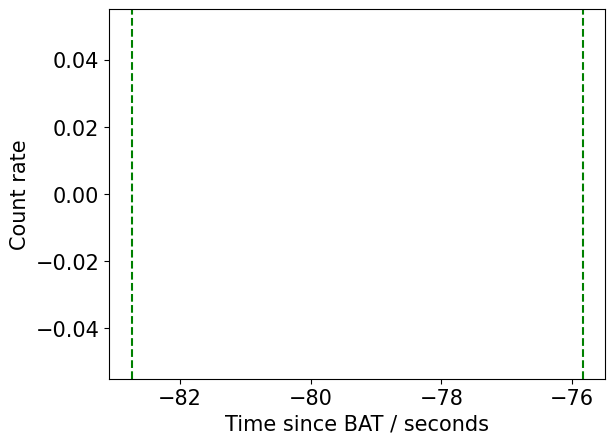

//////////////////////////////////////////////////////////// GRB130815B ////////////////////////////////////////////////////////////
1.056
------------------------------------------------------------ Tpre ------------------------------------------------------------


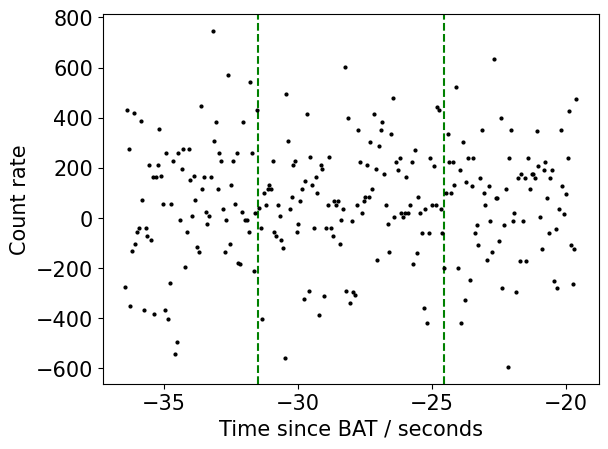

//////////////////////////////////////////////////////////// GRB141029B ////////////////////////////////////////////////////////////
1.95
------------------------------------------------------------ Tpre ------------------------------------------------------------


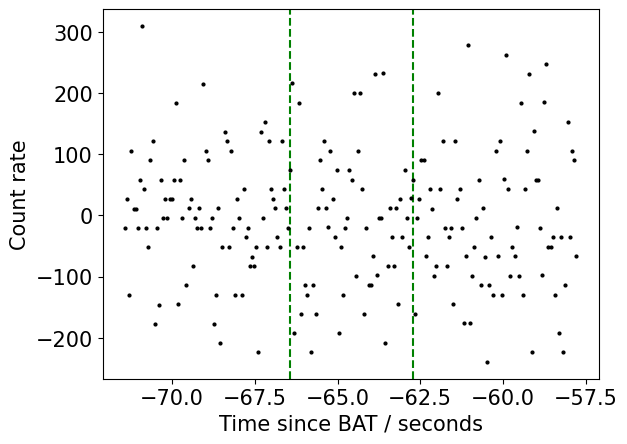

//////////////////////////////////////////////////////////// GRB180822B ////////////////////////////////////////////////////////////
1.639
------------------------------------------------------------ Tpre ------------------------------------------------------------


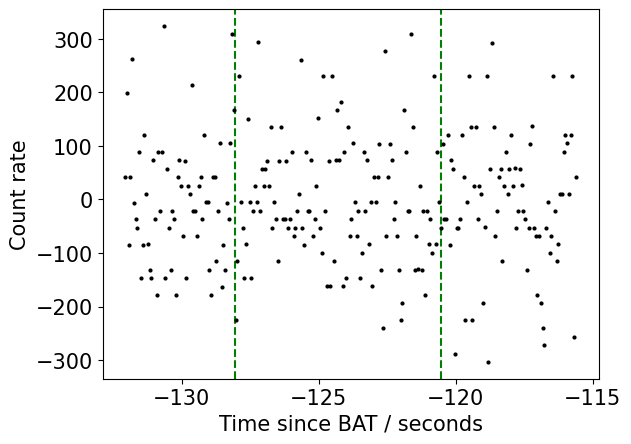

//////////////////////////////////////////////////////////// GRB110725A ////////////////////////////////////////////////////////////
1.056
------------------------------------------------------------ Tpre ------------------------------------------------------------


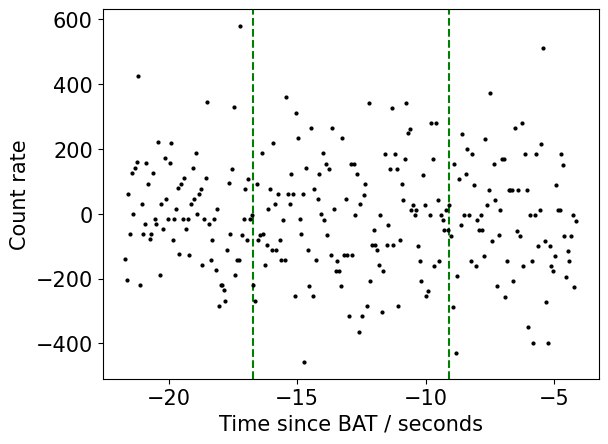

//////////////////////////////////////////////////////////// GRB140404A ////////////////////////////////////////////////////////////
5.91
------------------------------------------------------------ Tpre ------------------------------------------------------------


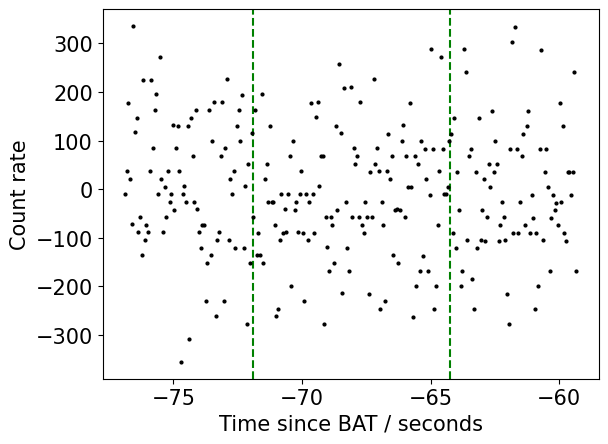

//////////////////////////////////////////////////////////// GRB161119A ////////////////////////////////////////////////////////////
2.36
------------------------------------------------------------ Tpre ------------------------------------------------------------


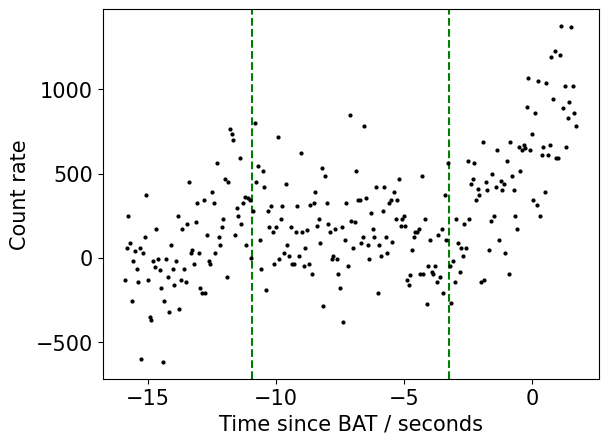

//////////////////////////////////////////////////////////// GRB150522A ////////////////////////////////////////////////////////////
3.874
------------------------------------------------------------ Tpre ------------------------------------------------------------


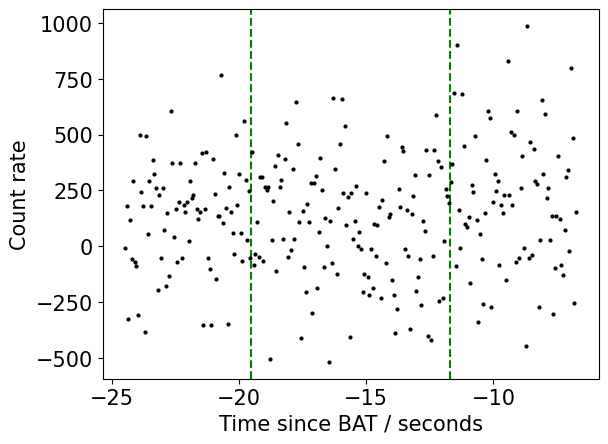

//////////////////////////////////////////////////////////// GRB081121A ////////////////////////////////////////////////////////////
8.51
------------------------------------------------------------ Tpre ------------------------------------------------------------


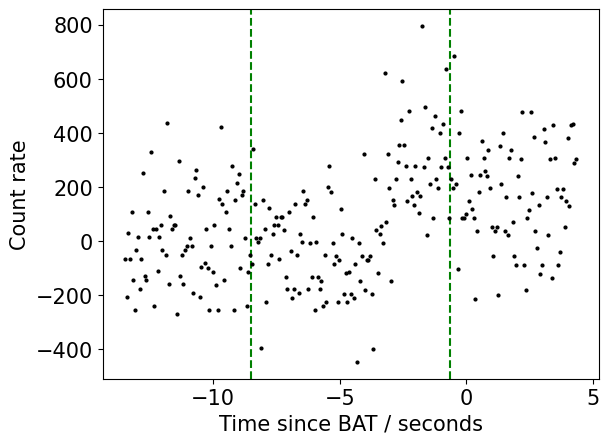

//////////////////////////////////////////////////////////// GRB190228A ////////////////////////////////////////////////////////////
6.085
------------------------------------------------------------ Tpre ------------------------------------------------------------


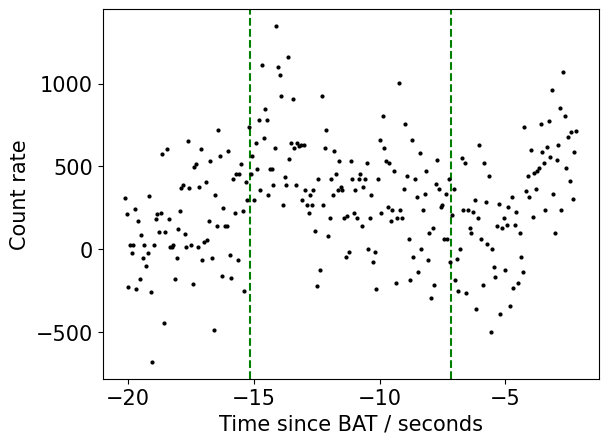

//////////////////////////////////////////////////////////// GRB170209A ////////////////////////////////////////////////////////////
2.064
------------------------------------------------------------ Tpre ------------------------------------------------------------


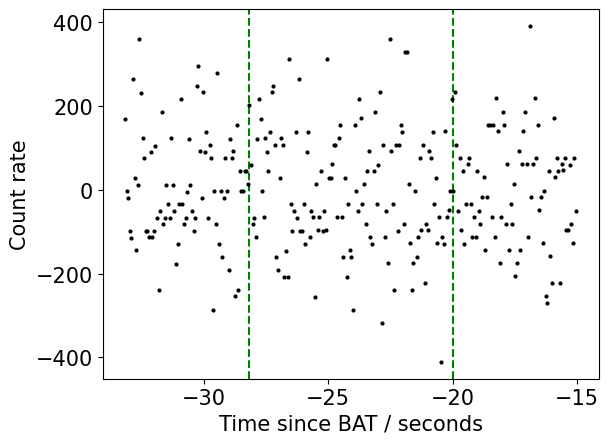

//////////////////////////////////////////////////////////// GRB130404B ////////////////////////////////////////////////////////////
2.573
------------------------------------------------------------ Tpre ------------------------------------------------------------


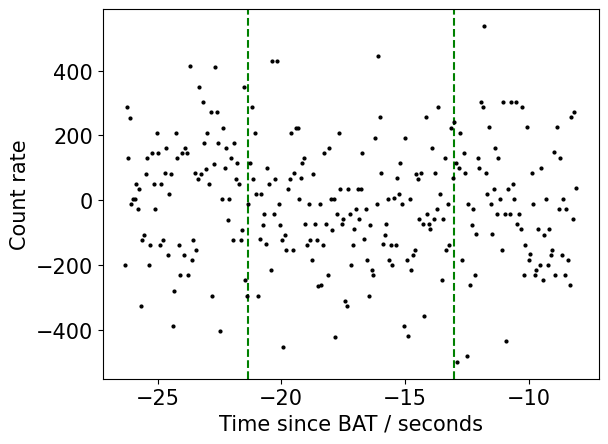

//////////////////////////////////////////////////////////// GRB170831A ////////////////////////////////////////////////////////////
8.738
------------------------------------------------------------ Tpre ------------------------------------------------------------


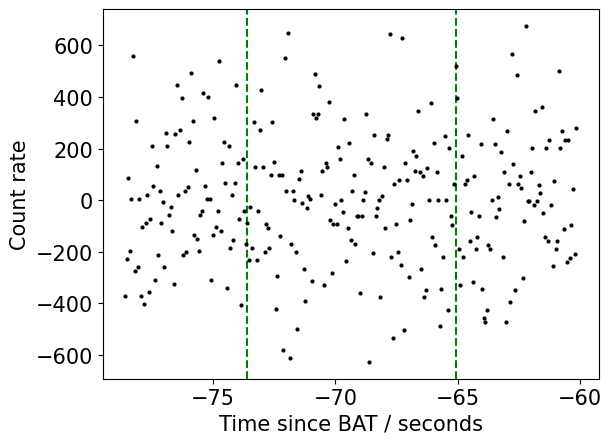

//////////////////////////////////////////////////////////// GRB130818A ////////////////////////////////////////////////////////////
3.183
------------------------------------------------------------ Tpre ------------------------------------------------------------


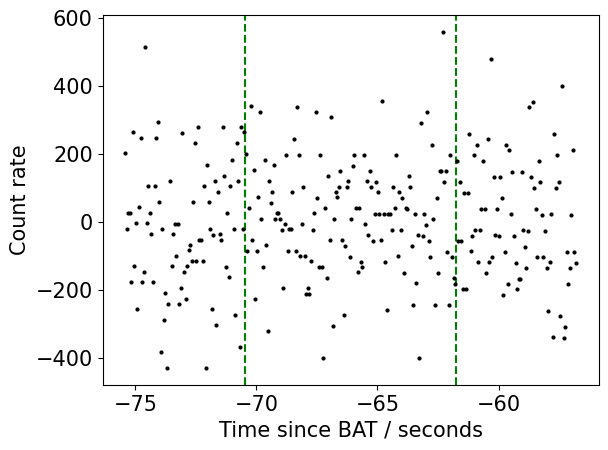

//////////////////////////////////////////////////////////// GRB190205A ////////////////////////////////////////////////////////////
5.03
------------------------------------------------------------ Tpre ------------------------------------------------------------


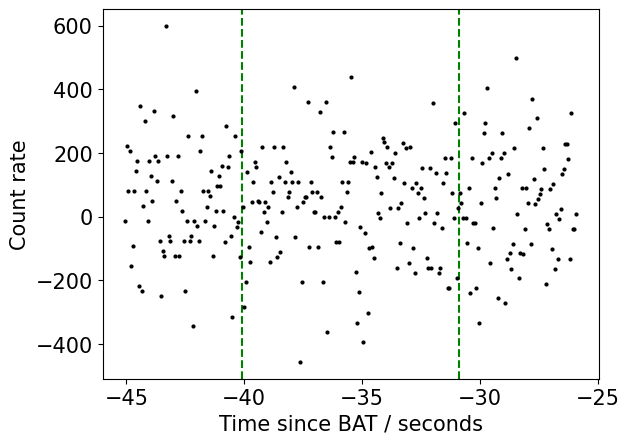

//////////////////////////////////////////////////////////// GRB160512A ////////////////////////////////////////////////////////////
3.566
------------------------------------------------------------ Tpre ------------------------------------------------------------


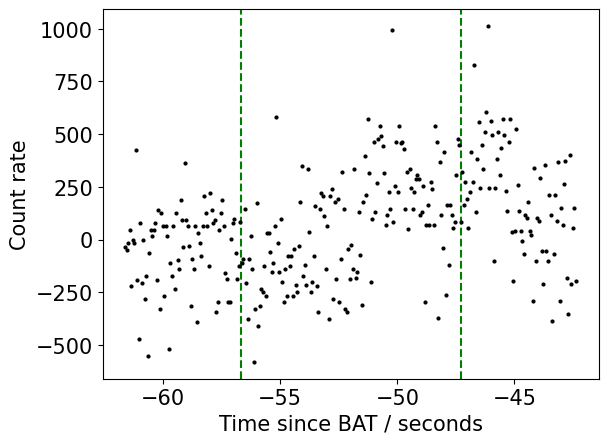

//////////////////////////////////////////////////////////// GRB180720B ////////////////////////////////////////////////////////////
0.362
------------------------------------------------------------ Tpre ------------------------------------------------------------


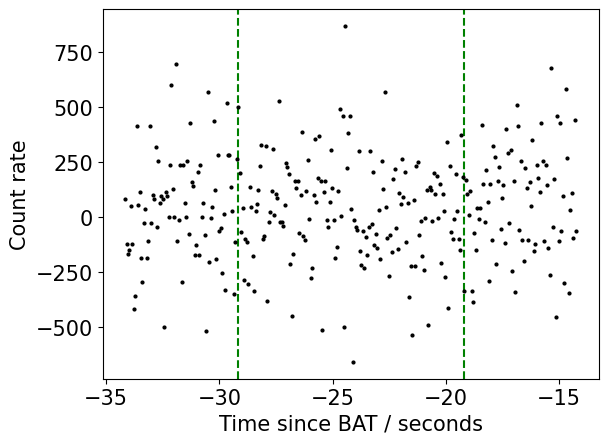

//////////////////////////////////////////////////////////// GRB180728A ////////////////////////////////////////////////////////////
0.362
------------------------------------------------------------ Tpre ------------------------------------------------------------


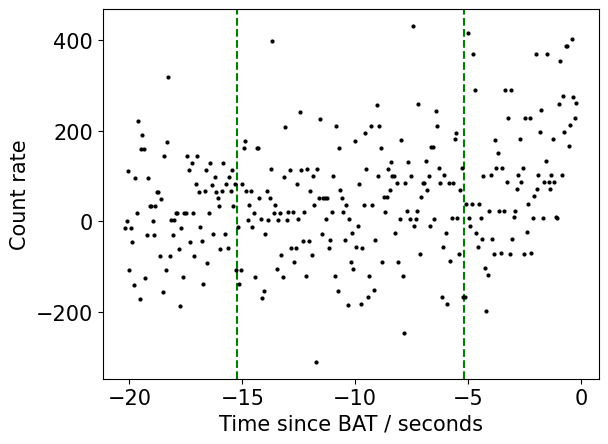

//////////////////////////////////////////////////////////// GRB140818A ////////////////////////////////////////////////////////////
0.932
------------------------------------------------------------ Tpre ------------------------------------------------------------


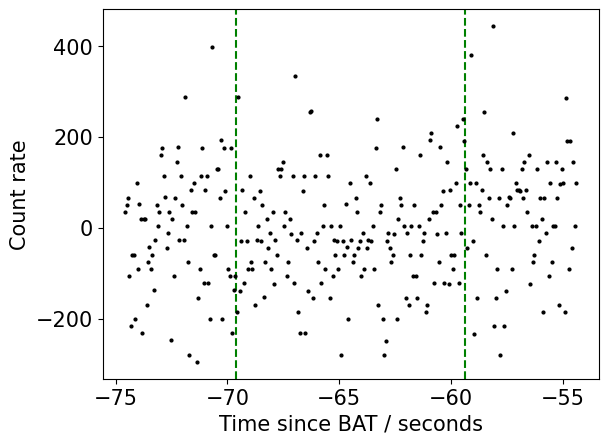

//////////////////////////////////////////////////////////// GRB180416A ////////////////////////////////////////////////////////////
6.405
------------------------------------------------------------ Tpre ------------------------------------------------------------


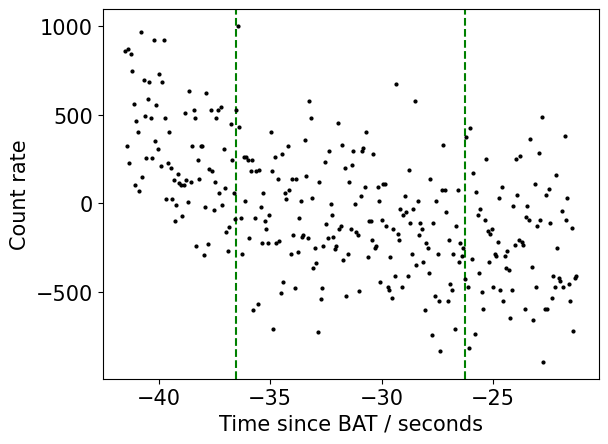

//////////////////////////////////////////////////////////// GRB171102A ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


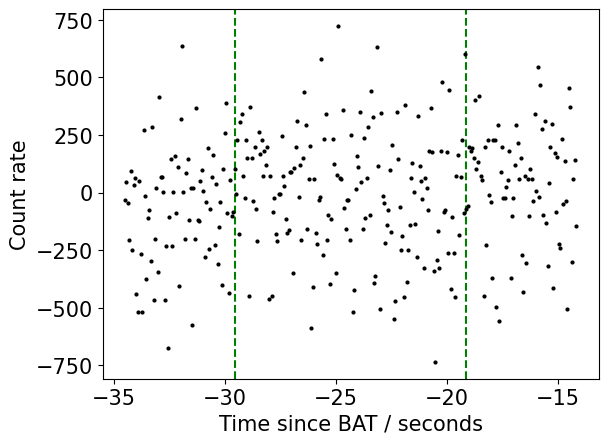

//////////////////////////////////////////////////////////// GRB160223A ////////////////////////////////////////////////////////////
3.208
------------------------------------------------------------ Tpre ------------------------------------------------------------


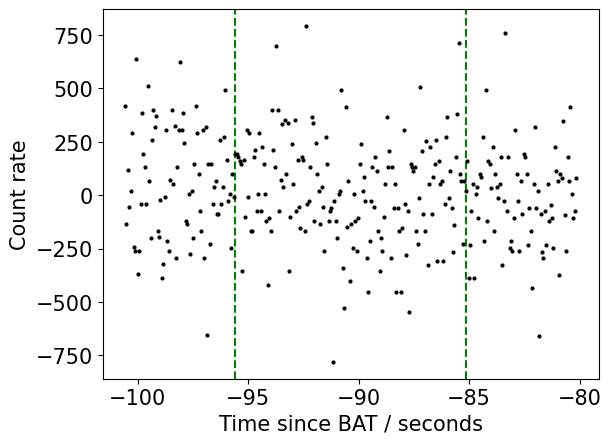

//////////////////////////////////////////////////////////// GRB161111A ////////////////////////////////////////////////////////////
2.673
------------------------------------------------------------ Tpre ------------------------------------------------------------


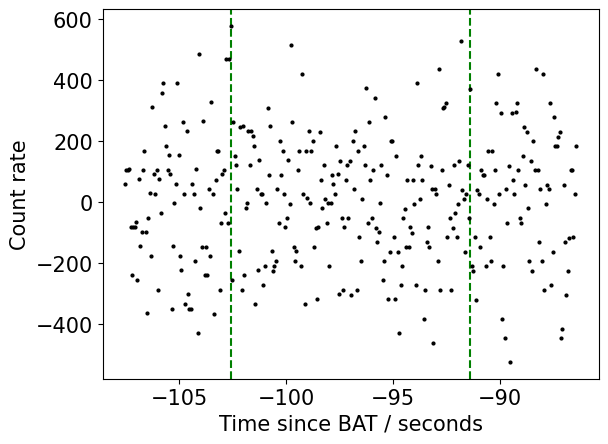

//////////////////////////////////////////////////////////// GRB150330A ////////////////////////////////////////////////////////////
0.81
------------------------------------------------------------ Tpre ------------------------------------------------------------


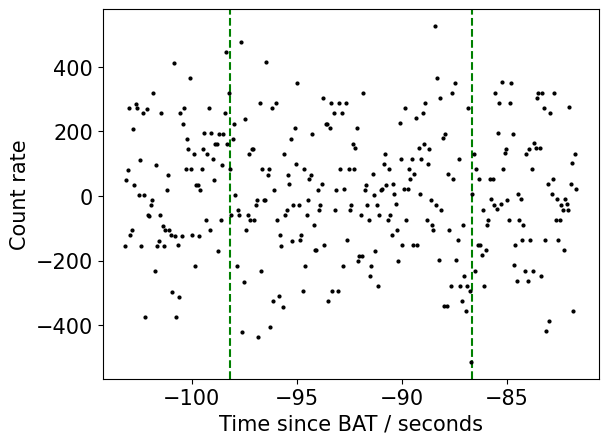

//////////////////////////////////////////////////////////// GRB140108A ////////////////////////////////////////////////////////////
2.36
------------------------------------------------------------ Tpre ------------------------------------------------------------


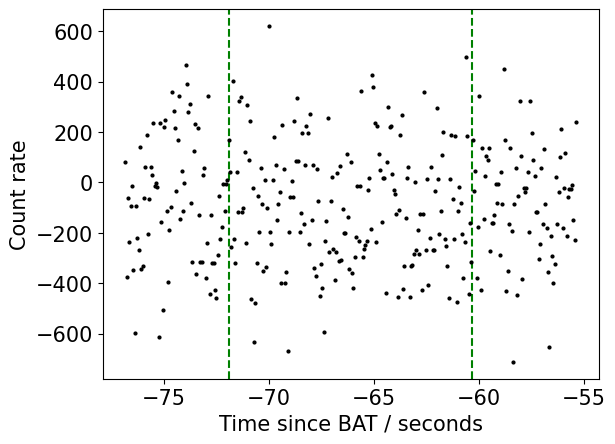

//////////////////////////////////////////////////////////// GRB140512A ////////////////////////////////////////////////////////////
2.36
------------------------------------------------------------ Tpre ------------------------------------------------------------


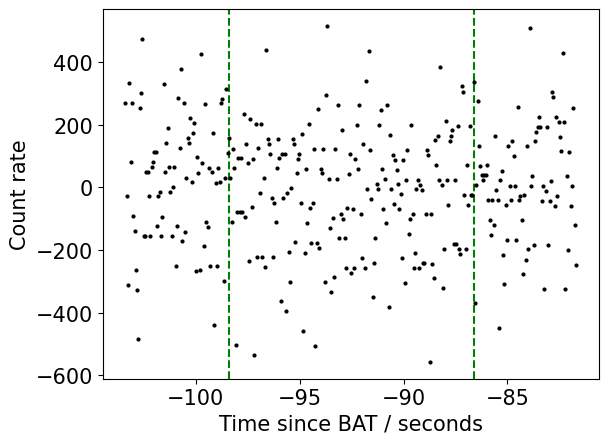

//////////////////////////////////////////////////////////// GRB140825B ////////////////////////////////////////////////////////////
5.184
------------------------------------------------------------ Tpre ------------------------------------------------------------


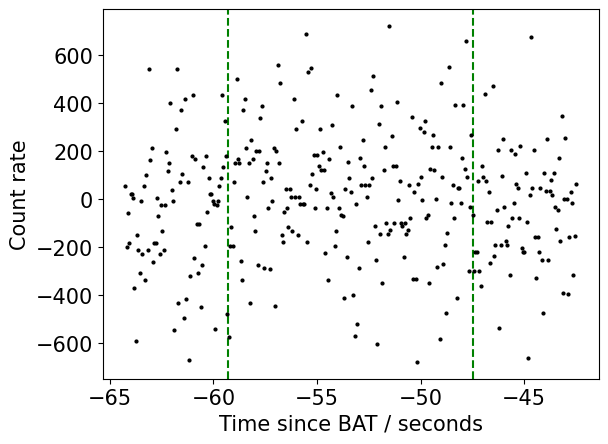

//////////////////////////////////////////////////////////// GRB170302B ////////////////////////////////////////////////////////////
5.526
------------------------------------------------------------ Tpre ------------------------------------------------------------


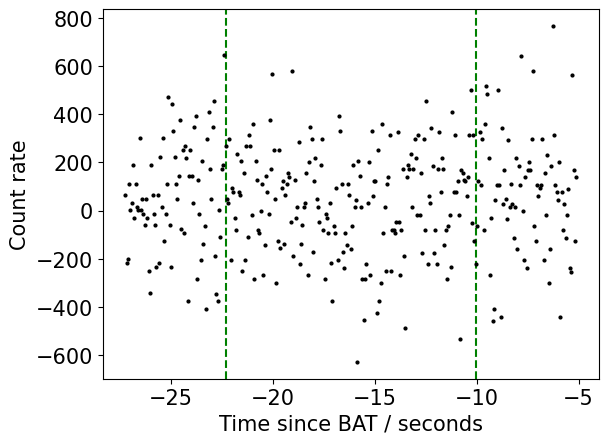

//////////////////////////////////////////////////////////// GRB171211B ////////////////////////////////////////////////////////////
3.125
------------------------------------------------------------ Tpre ------------------------------------------------------------


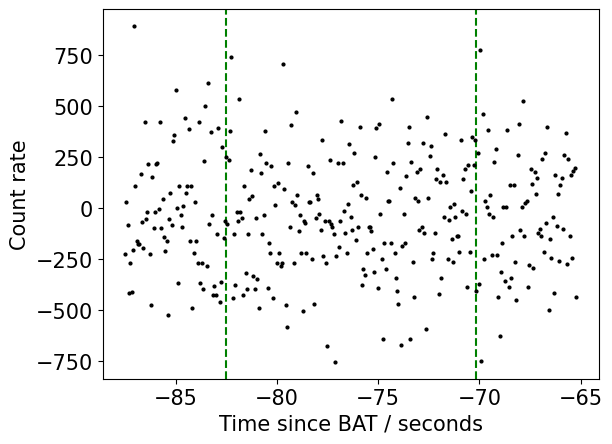

//////////////////////////////////////////////////////////// GRB090131A ////////////////////////////////////////////////////////////
1.056
------------------------------------------------------------ Tpre ------------------------------------------------------------


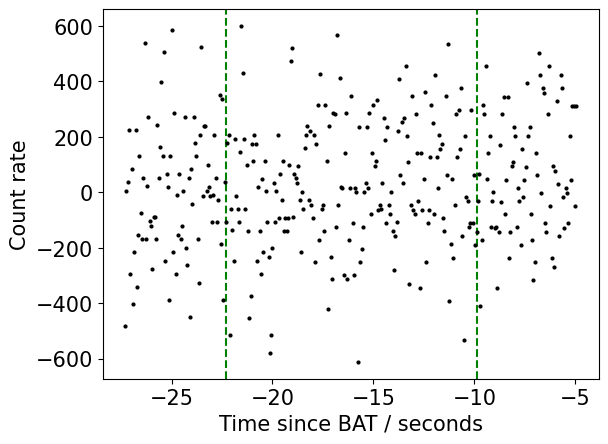

//////////////////////////////////////////////////////////// GRB170323B ////////////////////////////////////////////////////////////
5.4
------------------------------------------------------------ Tpre ------------------------------------------------------------


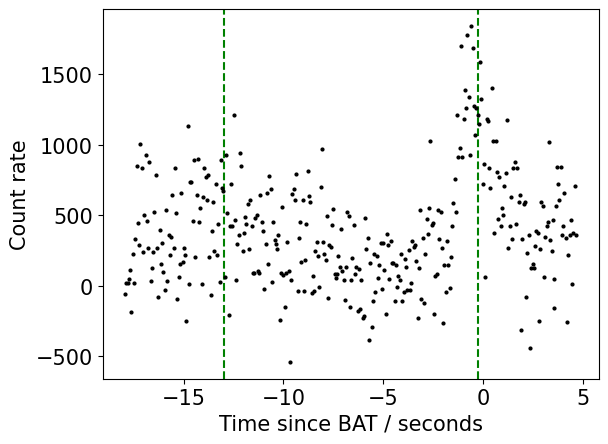

//////////////////////////////////////////////////////////// GRB161105B ////////////////////////////////////////////////////////////
1.086
------------------------------------------------------------ Tpre ------------------------------------------------------------


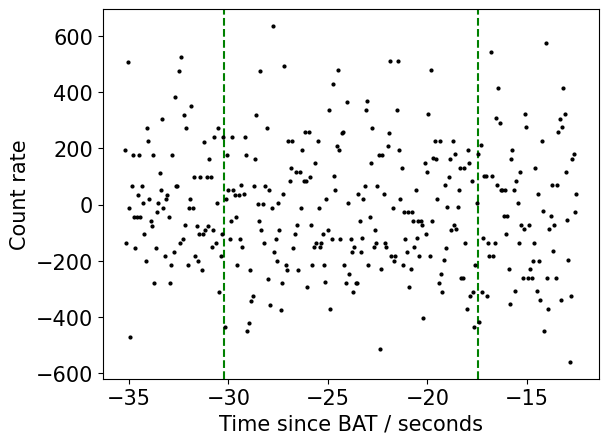

//////////////////////////////////////////////////////////// GRB140824B ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


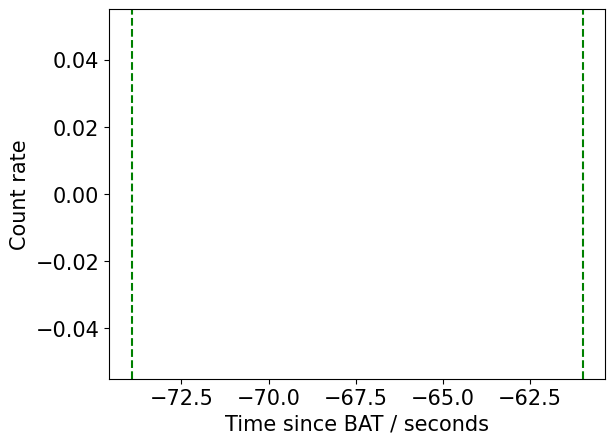

//////////////////////////////////////////////////////////// GRB150126A ////////////////////////////////////////////////////////////
3.114
------------------------------------------------------------ Tpre ------------------------------------------------------------


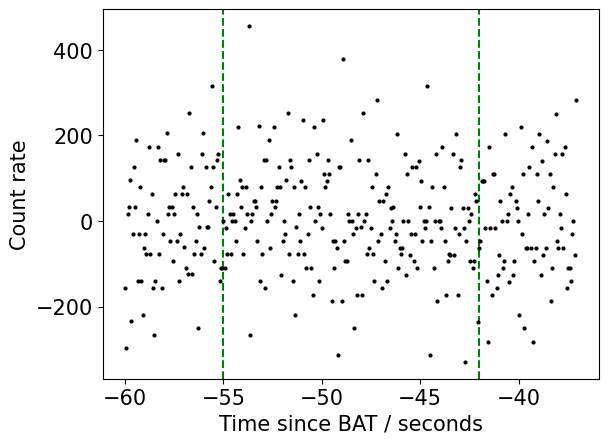

//////////////////////////////////////////////////////////// GRB150830A ////////////////////////////////////////////////////////////
0.724
------------------------------------------------------------ Tpre ------------------------------------------------------------


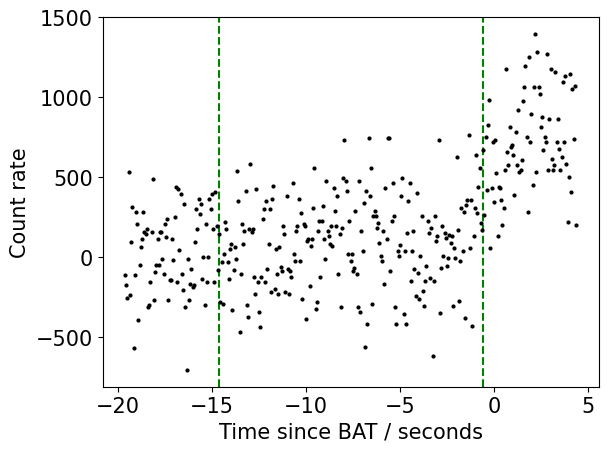

//////////////////////////////////////////////////////////// GRB140126A ////////////////////////////////////////////////////////////
2.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


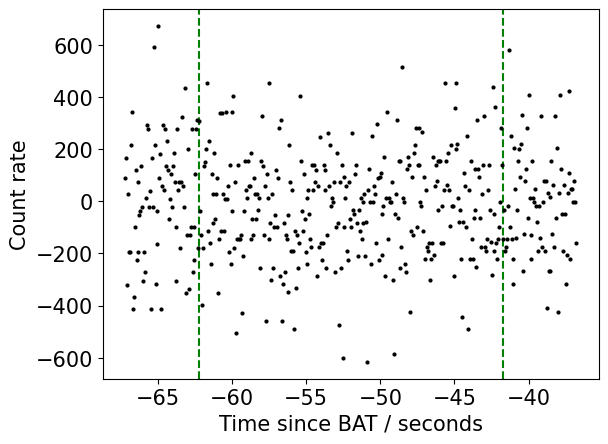

//////////////////////////////////////////////////////////// GRB100204B ////////////////////////////////////////////////////////////
2.862
------------------------------------------------------------ Tpre ------------------------------------------------------------


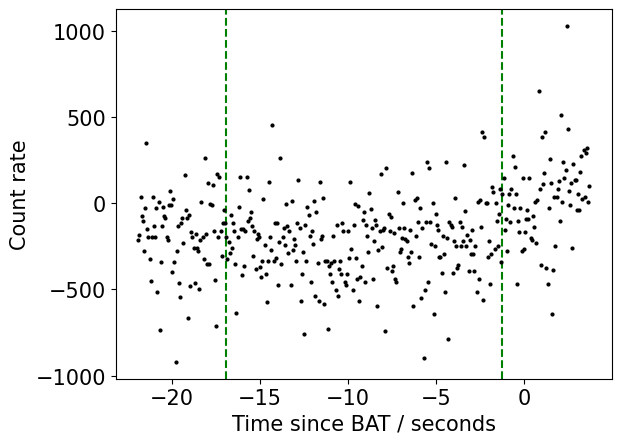

//////////////////////////////////////////////////////////// GRB150508A ////////////////////////////////////////////////////////////
1.619
------------------------------------------------------------ Tpre ------------------------------------------------------------


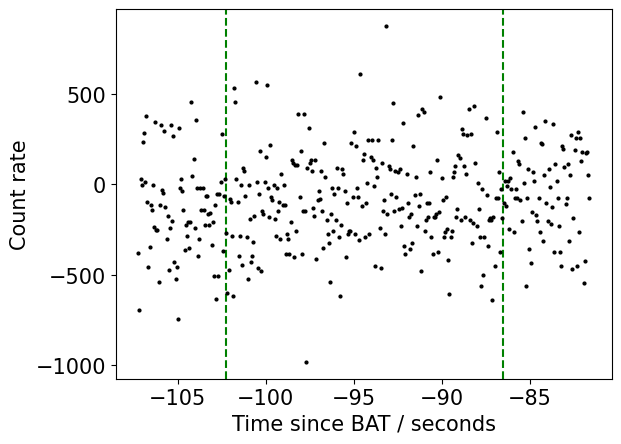

//////////////////////////////////////////////////////////// GRB191111A ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


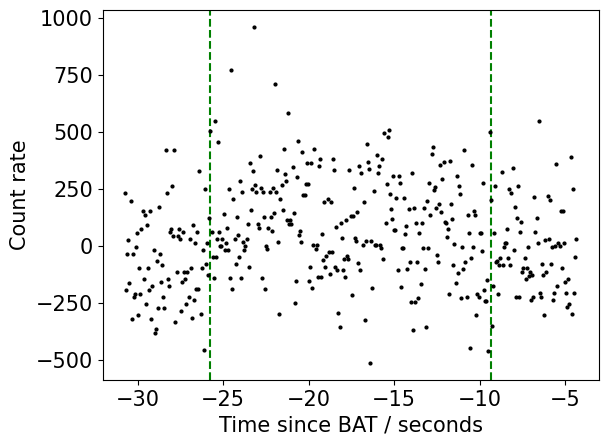

//////////////////////////////////////////////////////////// GRB130418B ////////////////////////////////////////////////////////////
2.56
------------------------------------------------------------ Tpre ------------------------------------------------------------


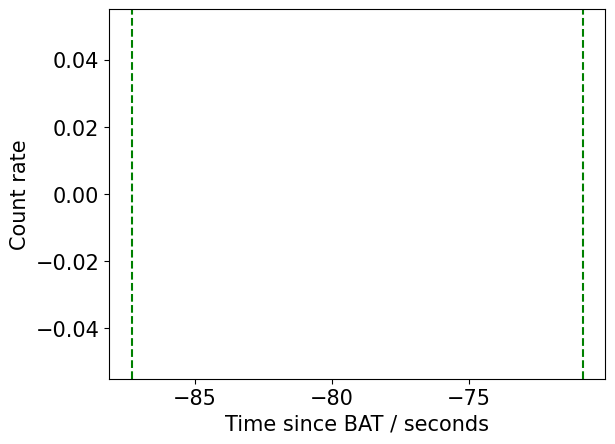

//////////////////////////////////////////////////////////// GRB160519A ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


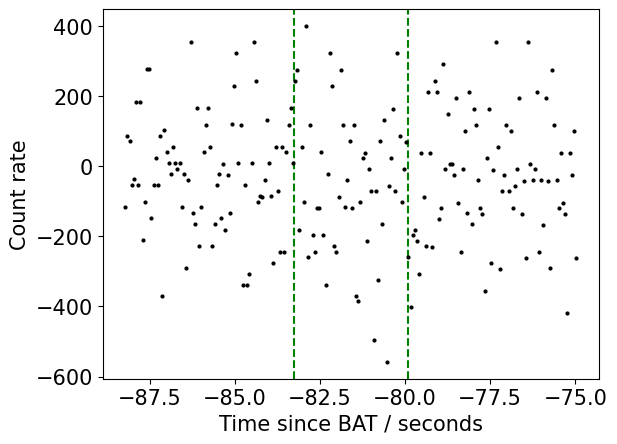

//////////////////////////////////////////////////////////// GRB111015A ////////////////////////////////////////////////////////////
3.319
------------------------------------------------------------ Tpre ------------------------------------------------------------


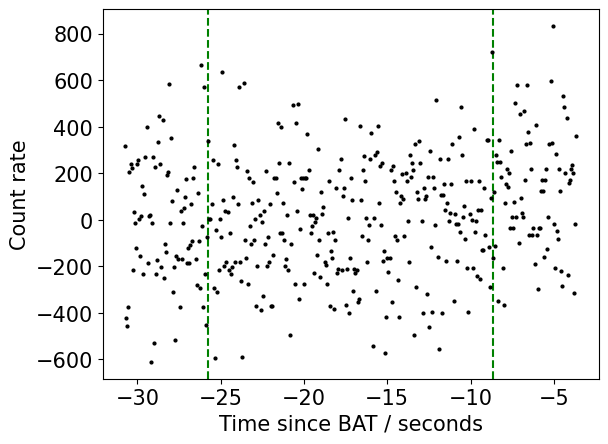

//////////////////////////////////////////////////////////// GRB130106B ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


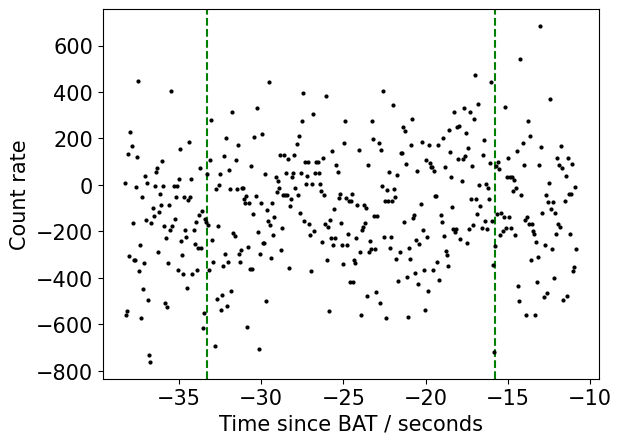

//////////////////////////////////////////////////////////// GRB151030A ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


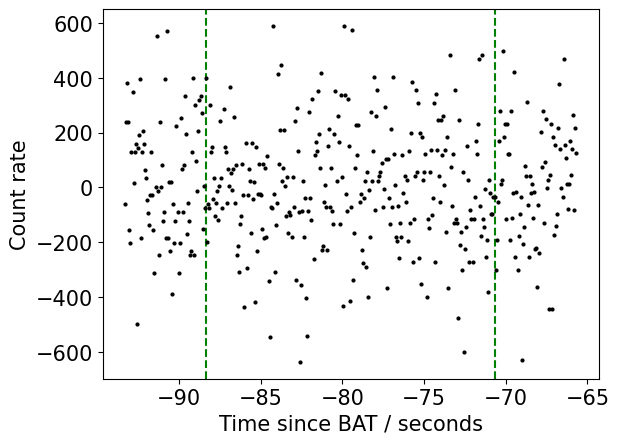

//////////////////////////////////////////////////////////// GRB090428A ////////////////////////////////////////////////////////////
1.506
------------------------------------------------------------ Tpre ------------------------------------------------------------


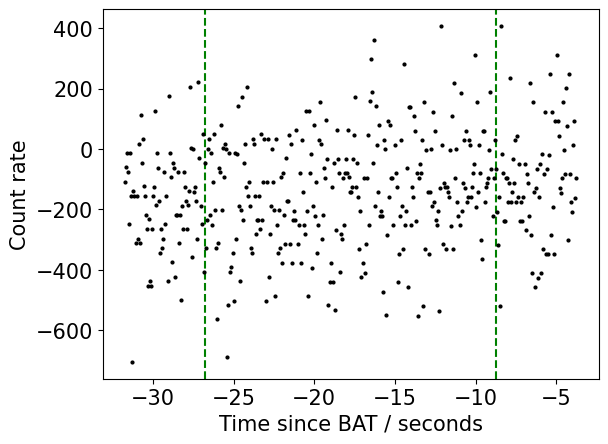

//////////////////////////////////////////////////////////// GRB170115C ////////////////////////////////////////////////////////////
4.871
------------------------------------------------------------ Tpre ------------------------------------------------------------


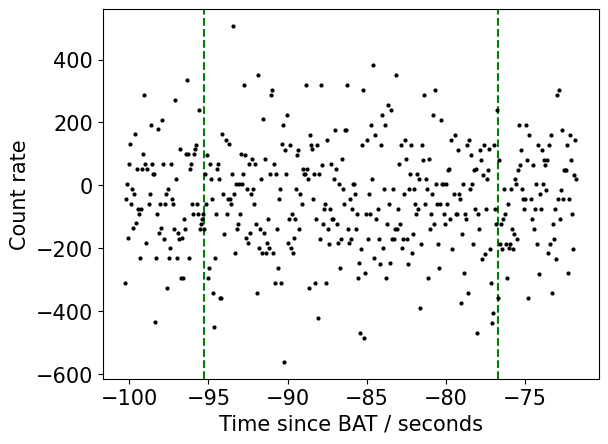

//////////////////////////////////////////////////////////// GRB150523A ////////////////////////////////////////////////////////////
2.573
------------------------------------------------------------ Tpre ------------------------------------------------------------


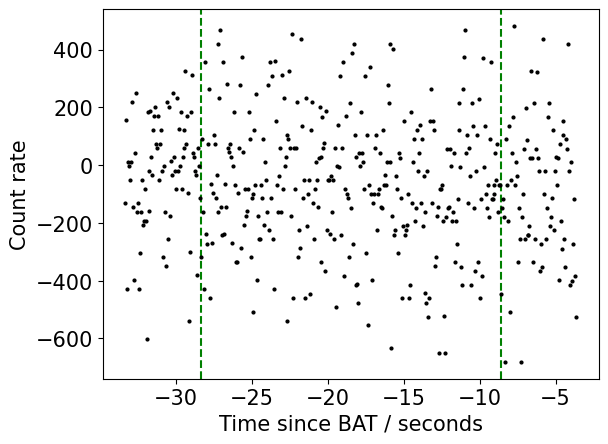

//////////////////////////////////////////////////////////// GRB190901A ////////////////////////////////////////////////////////////
1.717
------------------------------------------------------------ Tpre ------------------------------------------------------------


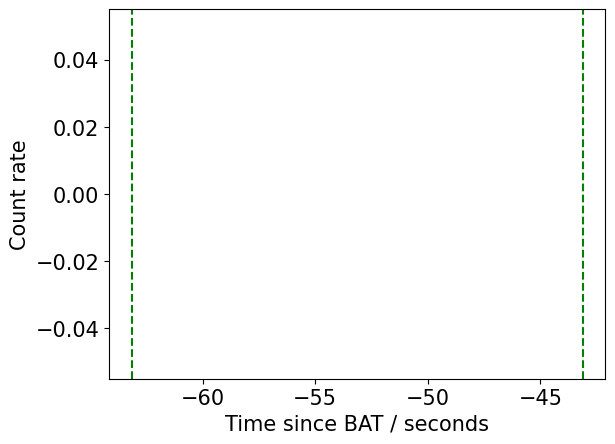

//////////////////////////////////////////////////////////// GRB190611B ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


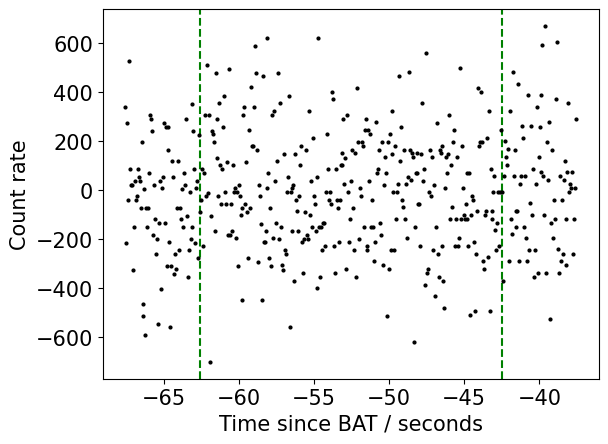

//////////////////////////////////////////////////////////// GRB150512A ////////////////////////////////////////////////////////////
3.167
------------------------------------------------------------ Tpre ------------------------------------------------------------


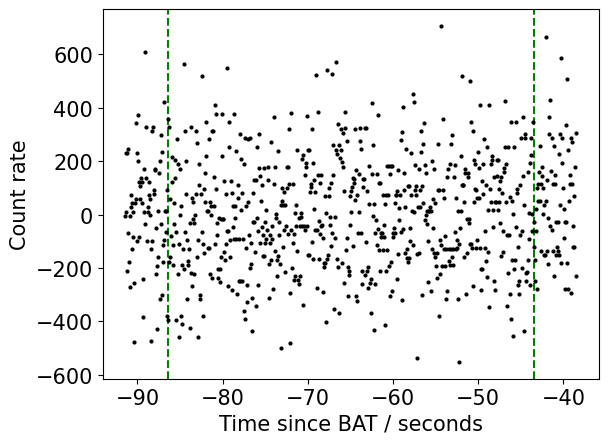

//////////////////////////////////////////////////////////// GRB130219A ////////////////////////////////////////////////////////////
0.405
------------------------------------------------------------ Tpre ------------------------------------------------------------


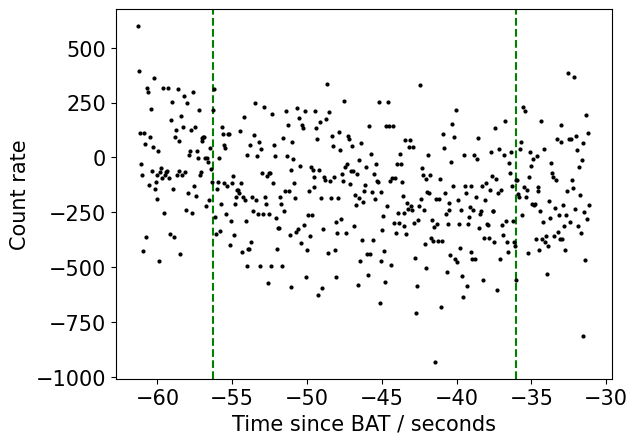

//////////////////////////////////////////////////////////// GRB140126A ////////////////////////////////////////////////////////////
2.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


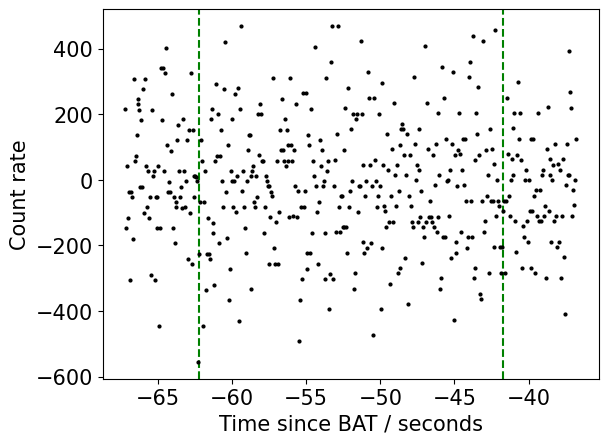

//////////////////////////////////////////////////////////// GRB110227B ////////////////////////////////////////////////////////////
2.187
------------------------------------------------------------ Tpre ------------------------------------------------------------


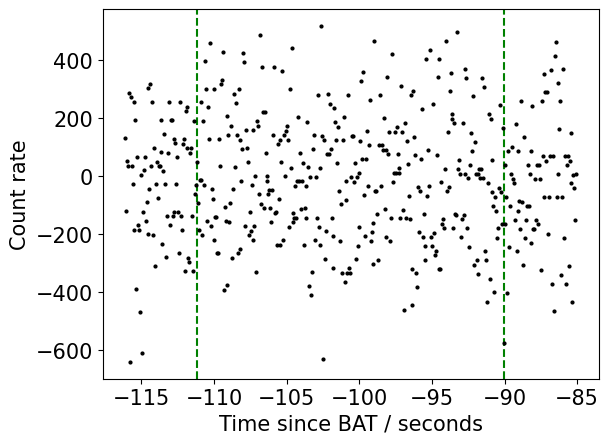

//////////////////////////////////////////////////////////// GRB160225B ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


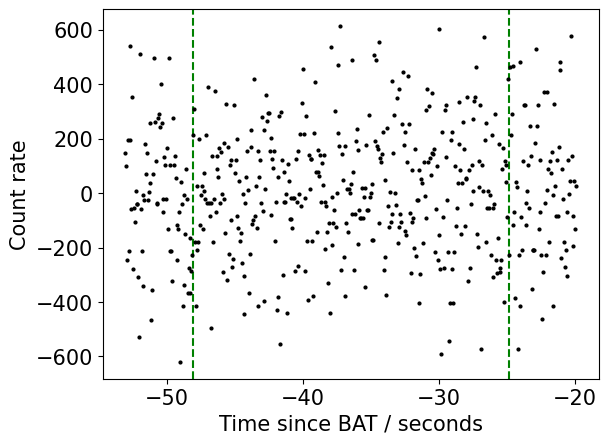

//////////////////////////////////////////////////////////// GRB180307A ////////////////////////////////////////////////////////////
1.379
------------------------------------------------------------ Tpre ------------------------------------------------------------


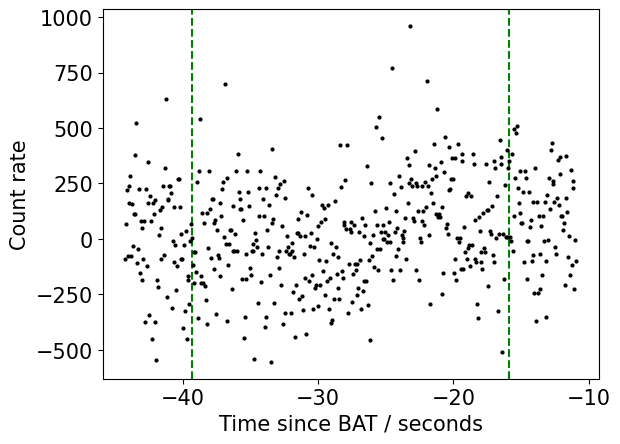

//////////////////////////////////////////////////////////// GRB180618B ////////////////////////////////////////////////////////////
1.28
------------------------------------------------------------ Tpre ------------------------------------------------------------


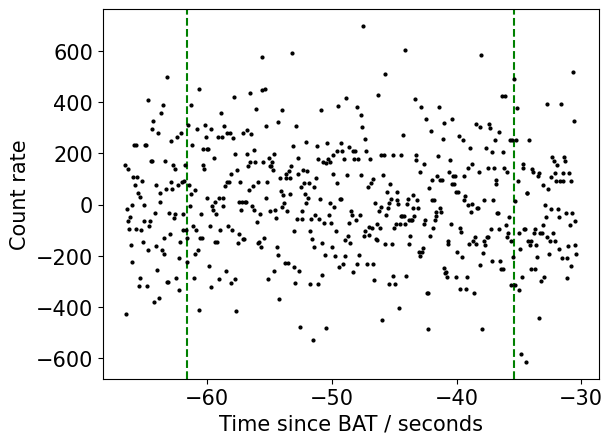

//////////////////////////////////////////////////////////// GRB180411A ////////////////////////////////////////////////////////////
2.996
------------------------------------------------------------ Tpre ------------------------------------------------------------


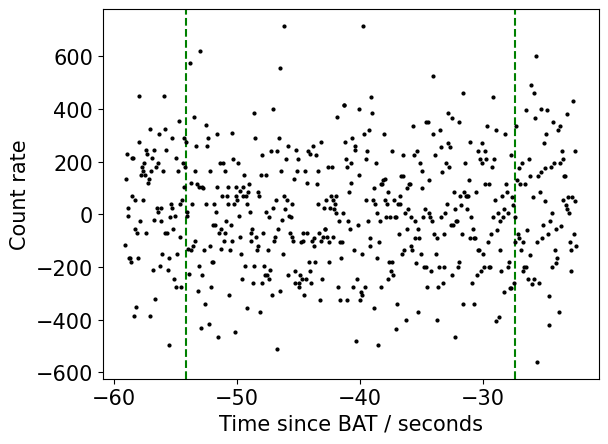

//////////////////////////////////////////////////////////// GRB140714A ////////////////////////////////////////////////////////////
2.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


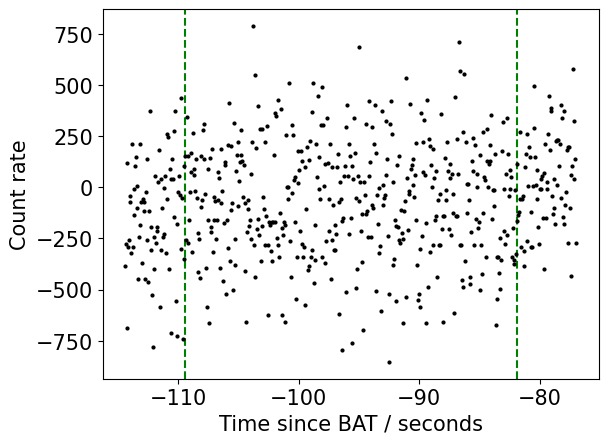

//////////////////////////////////////////////////////////// GRB150506A ////////////////////////////////////////////////////////////
1.282
------------------------------------------------------------ Tpre ------------------------------------------------------------


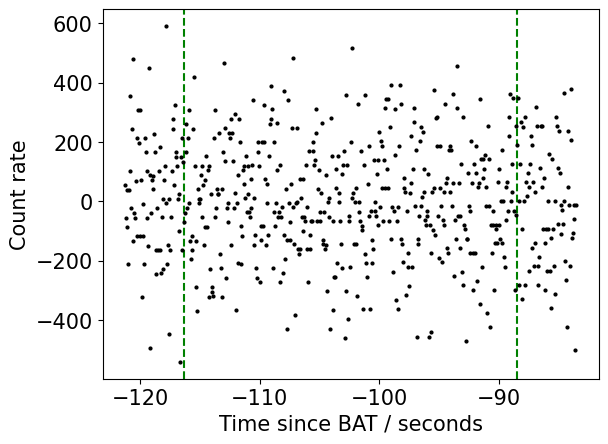

//////////////////////////////////////////////////////////// GRB181008B ////////////////////////////////////////////////////////////
5.615
------------------------------------------------------------ Tpre ------------------------------------------------------------


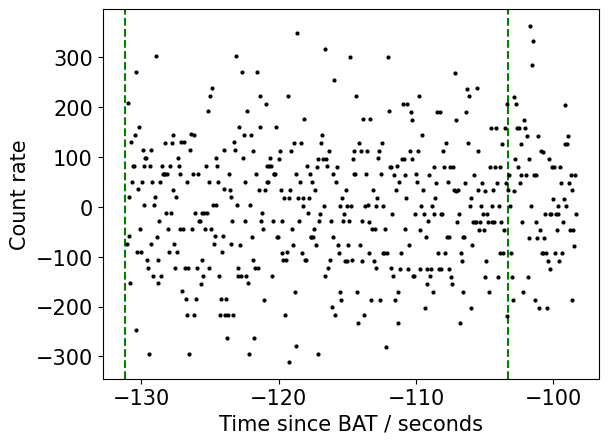

//////////////////////////////////////////////////////////// GRB080723B ////////////////////////////////////////////////////////////
1.985
------------------------------------------------------------ Tpre ------------------------------------------------------------


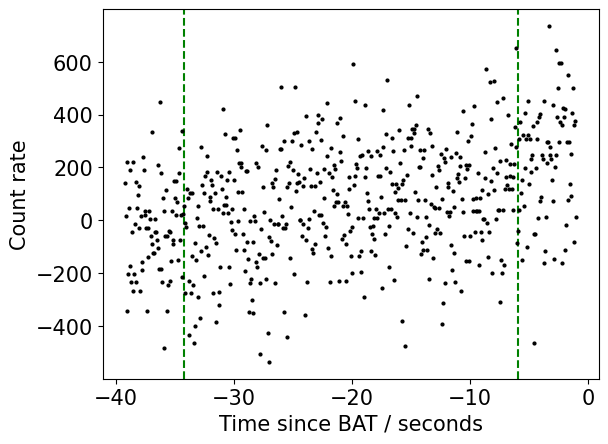

//////////////////////////////////////////////////////////// GRB191019B ////////////////////////////////////////////////////////////
0.572
------------------------------------------------------------ Tpre ------------------------------------------------------------


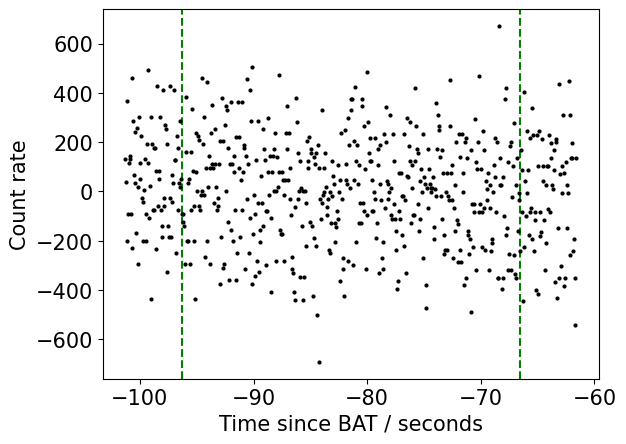

//////////////////////////////////////////////////////////// GRB160821A ////////////////////////////////////////////////////////////
0.724
------------------------------------------------------------ Tpre ------------------------------------------------------------


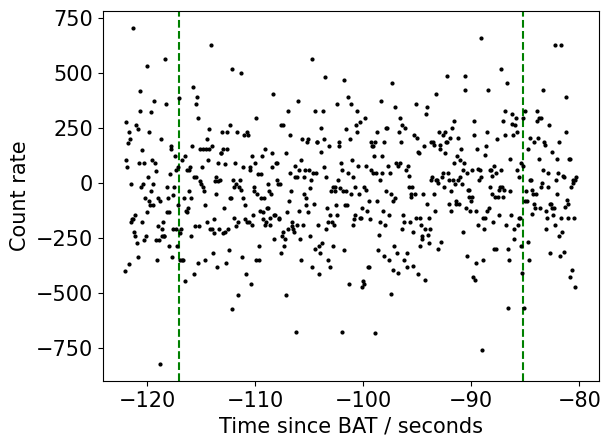

//////////////////////////////////////////////////////////// GRB170514A ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


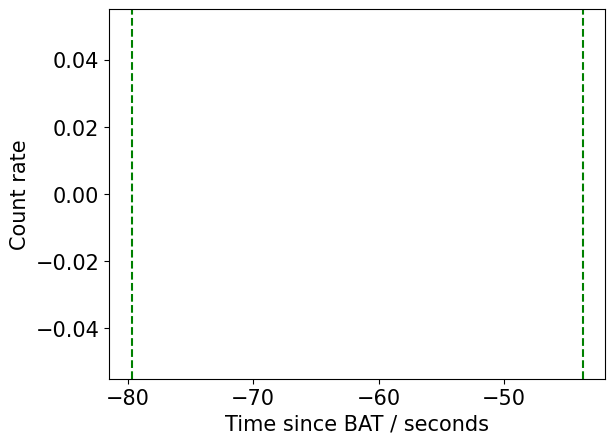

//////////////////////////////////////////////////////////// GRB160912C ////////////////////////////////////////////////////////////
0.923
------------------------------------------------------------ Tpre ------------------------------------------------------------


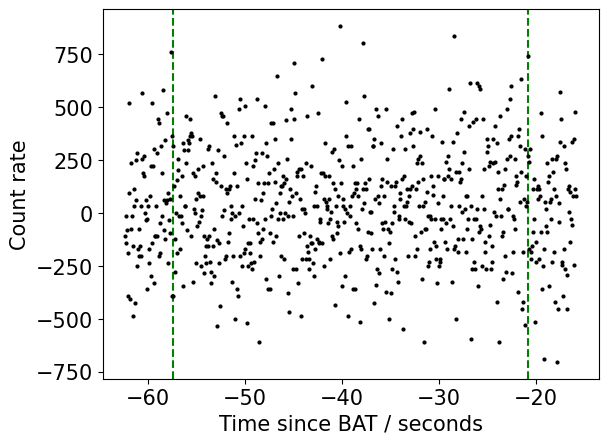

//////////////////////////////////////////////////////////// GRB190828B ////////////////////////////////////////////////////////////
1.999
------------------------------------------------------------ Tpre ------------------------------------------------------------


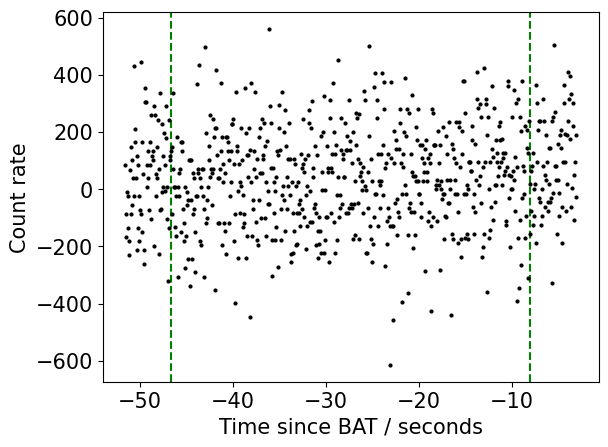

//////////////////////////////////////////////////////////// GRB151027A ////////////////////////////////////////////////////////////
1.145
------------------------------------------------------------ Tpre ------------------------------------------------------------


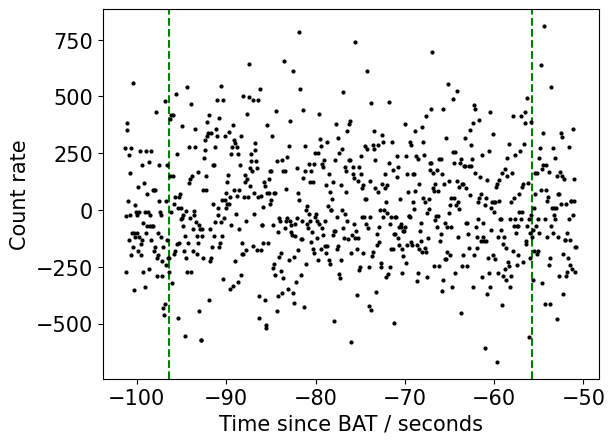

//////////////////////////////////////////////////////////// GRB150512A ////////////////////////////////////////////////////////////
3.167
------------------------------------------------------------ Tpre ------------------------------------------------------------


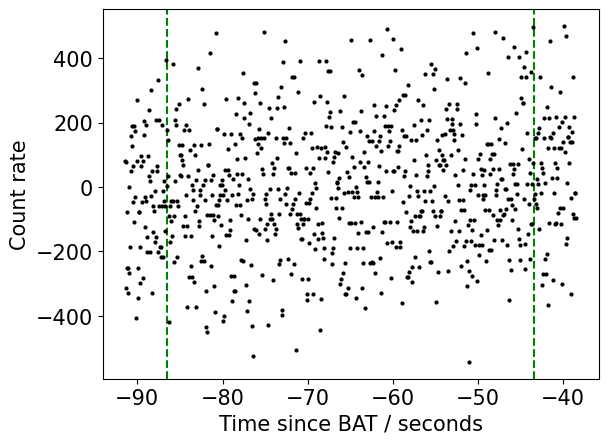

//////////////////////////////////////////////////////////// GRB160215A ////////////////////////////////////////////////////////////
1.28
------------------------------------------------------------ Tpre ------------------------------------------------------------


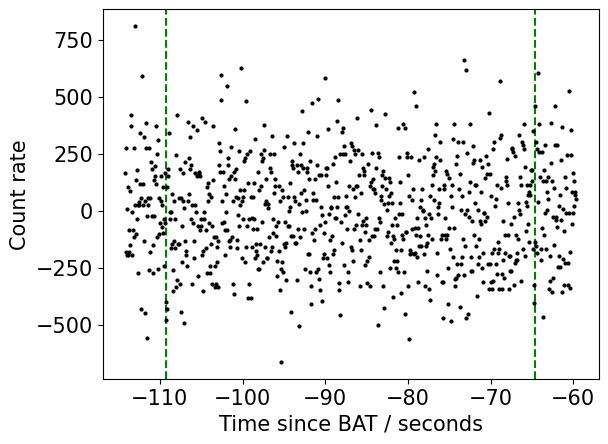

//////////////////////////////////////////////////////////// GRB110729A ////////////////////////////////////////////////////////////
2.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


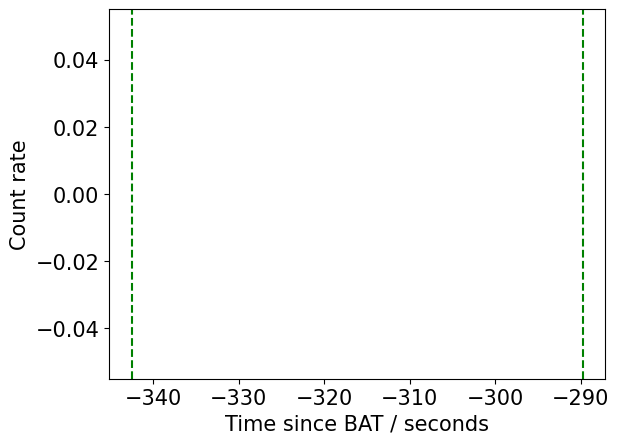

//////////////////////////////////////////////////////////// GRB110729A ////////////////////////////////////////////////////////////
2.29
------------------------------------------------------------ Tpre ------------------------------------------------------------


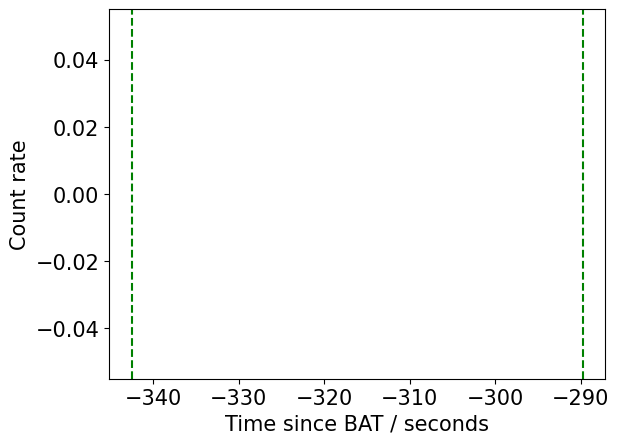

//////////////////////////////////////////////////////////// GRB140104B ////////////////////////////////////////////////////////////
2.996
------------------------------------------------------------ Tpre ------------------------------------------------------------


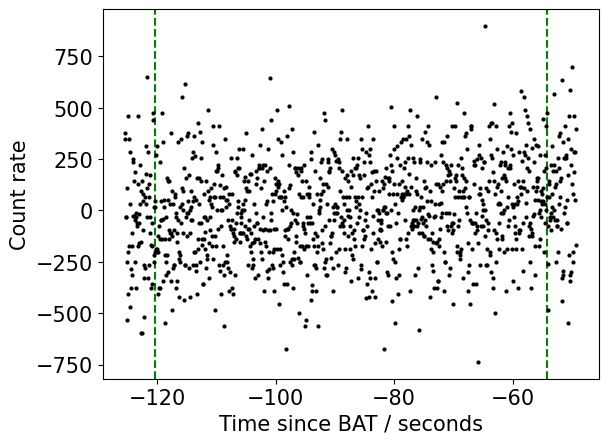

//////////////////////////////////////////////////////////// GRB161117A ////////////////////////////////////////////////////////////
0.659
------------------------------------------------------------ Tpre ------------------------------------------------------------


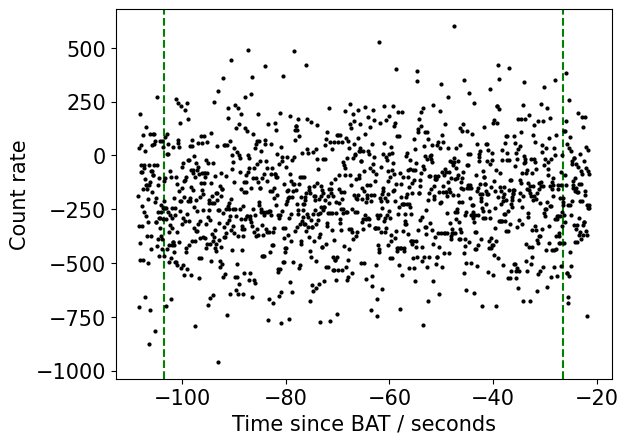

In [6]:
# Plot Tpres 
for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname), start=len(MVT_DF.get_dataframe())):
    
    print_banner(GRB_name)
    T90_min, T90_max, T90_err = get_Tmin_Tmax(GRB_name, T90)
    TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
    print(T90_err)

    for Tx in ['T90', 'Tpre']:

        if Tx == 'T90':
            continue 

        print_banner(Tx, '-')

        Tmin, Tmax = (T90_min, T90_max) if Tx == 'T90' else (TPre_min, TPre_max)
        scale = 5
        refine = Refine(Tmin=Tmin, Tmax=Tmax, scale=scale, degree=6, multiplier=1.4)


        GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=refine.Tmin - scale, Tmax=refine.Tmax + scale)
        plot_func(data=GRB, x_axis='TIME', y_axis='RATE', Sig_or_LC='LC', window_size=4,  t90=[refine.Tmin, refine.Tmax])

        GRB = GRB[(GRB['TIME'] > refine.Tmin) & (GRB['TIME'] < refine.Tmax)]
        GRB.reset_index(drop=True, inplace=True)